# Part 1
## Step 1 - Prepare first part of data

In [3]:
import os
import zipfile
import requests
import pandas as pd

# Создаем рабочую папку
datasets_path = "datasets"
os.makedirs(datasets_path, exist_ok=True)

# Функция для скачивания и распаковки архивов
def download_and_extract(url, dest_folder, file_name=None, extract_only=None):
    local_filename = os.path.join(dest_folder, file_name or url.split('/')[-1])
    response = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded: {local_filename}")

    # Распаковка архива
    try:
        if local_filename.endswith(".zip"):
            with zipfile.ZipFile(local_filename, 'r') as zip_ref:
                if extract_only:
                    for file in zip_ref.namelist():
                        if extract_only in file:
                            zip_ref.extract(file, dest_folder)
                            print(f"Extracted: {file}")
                else:
                    zip_ref.extractall(dest_folder)
        print(f"Extracted: {local_filename}")
    except Exception as e:
        print(f"Error extracting {local_filename}: {e}")
    os.remove(local_filename)  # Удаляем архив после распаковки

# Скачивание и обработка Smile
def download_smile():
    smile_zip_path = os.path.expanduser("~/Downloads/smile-twitter-emotion-dataset.zip")
    smile_dataset_path = os.path.join(datasets_path, "smile")
    os.makedirs(smile_dataset_path, exist_ok=True)

    print("Downloading Smile dataset using curl...")
    curl_command = [
        "curl", "-L", "-o", smile_zip_path,
        "https://www.kaggle.com/api/v1/datasets/download/ashkhagan/smile-twitter-emotion-dataset"
    ]
    subprocess.run(curl_command, check=True)
    print("Smile dataset downloaded.")

    print("Extracting Smile dataset...")
    with zipfile.ZipFile(smile_zip_path, 'r') as zip_ref:
        zip_ref.extractall(smile_dataset_path)
    os.remove(smile_zip_path)  # Удаляем архив после распаковки
    print(f"Smile dataset extracted to: {smile_dataset_path}")

# Скачивание и обработка RuSentiment
def download_rusentiment():
    rusentiment_url = "https://github.com/strawberrypie/rusentiment/archive/refs/heads/master.zip"
    rusentiment_dataset_path = os.path.join(datasets_path, "rusentiment")
    os.makedirs(rusentiment_dataset_path, exist_ok=True)

    rusentiment_zip_path = os.path.join(datasets_path, "rusentiment.zip")

    print("Downloading RuSentiment dataset...")
    response = requests.get(rusentiment_url, stream=True)
    with open(rusentiment_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("RuSentiment dataset downloaded.")

    print("Extracting necessary files from RuSentiment dataset...")
    with zipfile.ZipFile(rusentiment_zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith("rusentiment-master/Dataset/") and file.endswith(".csv"):
                zip_ref.extract(file, rusentiment_dataset_path)
                print(f"Extracted: {file}")

    # Перемещаем файлы в корневую папку rusentiment и удаляем промежуточные папки
    extracted_folder = os.path.join(rusentiment_dataset_path, "rusentiment-master", "Dataset")
    for file in os.listdir(extracted_folder):
        os.rename(os.path.join(extracted_folder, file), os.path.join(rusentiment_dataset_path, file))
    os.rmdir(extracted_folder)
    os.rmdir(os.path.join(rusentiment_dataset_path, "rusentiment-master"))
    os.remove(rusentiment_zip_path)
    print("RuSentiment dataset processed and cleaned.")

# Выполнение загрузки
try:
    download_smile()
    download_rusentiment()
except Exception as e:
    print(f"Error downloading datasets: {e}")

# Обработка Smile
smile_csv = os.path.join(datasets_path, "smile", "smile-annotations-final.csv")
if os.path.exists(smile_csv):
    smile_data = pd.read_csv(smile_csv, names=["id", "text", "emotion"], skiprows=1)
    print(f"Smile dataset loaded. Number of rows: {len(smile_data)}")
    print(smile_data.head())
else:
    print("Smile CSV not found!")

# Обработка RuSentiment
rusentiment_files = [
    "rusentiment_preselected_posts.csv",
    "rusentiment_random_posts.csv",
    "rusentiment_test.csv"
]
for file_name in rusentiment_files:
    file_path = os.path.join(datasets_path, "rusentiment", file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        print(f"Loaded {file_name}. Number of rows: {len(data)}")
        print(data.head())
    else:
        print(f"{file_name} not found!")

Smile dataset downloaded.
Extracting Smile dataset...
Smile dataset extracted to: datasets\smile
RuSentiment dataset downloaded.
Extracting necessary files from RuSentiment dataset...
Extracted: rusentiment-master/Dataset/rusentiment_preselected_posts.csv
Extracted: rusentiment-master/Dataset/rusentiment_random_posts.csv
Extracted: rusentiment-master/Dataset/rusentiment_test.csv
RuSentiment dataset processed and cleaned.
Smile dataset loaded. Number of rows: 3084
                   id                                               text  \
0  614484565059596288  Dorian Gray with Rainbow Scarf #LoveWins (from...   
1  614746522043973632  @SelectShowcase @Tate_StIves ... Replace with ...   
2  614877582664835073  @Sofabsports thank you for following me back. ...   
3  611932373039644672  @britishmuseum @TudorHistory What a beautiful ...   
4  611570404268883969  @NationalGallery @ThePoldarkian I have always ...   

  emotion  
0   happy  
1   happy  
2   happy  
3   happy  
4   happy  
Loa

In [ ]:
import pandas as pd
import random

# Загружаем датасеты
datasets_path = "datasets"
smile_path = f"{datasets_path}/smile/smile-annotations-final.csv"
rusentiment_path = f"{datasets_path}/rusentiment/rusentiment_random_posts.csv"

# Функция для выбора текстов с наибольшим количеством символов
def select_top_texts(dataset, column_name="text", top_n=100):
    dataset["text_length"] = dataset[column_name].apply(len)
    top_texts = dataset.nlargest(top_n, "text_length")[column_name].tolist()
    return top_texts

# Функция добавления шумов
def add_noise(text, noise_level):
    text = list(text)
    length = len(text)
    num_noisy_chars = int(length * noise_level)
    
    for _ in range(num_noisy_chars):
        noise_type = random.choice(["delete", "swap", "replace"])
        idx = random.randint(0, len(text) - 1)
        
        if noise_type == "delete" and len(text) > 1:
            del text[idx]
        elif noise_type == "swap" and idx < len(text) - 1:
            text[idx], text[idx + 1] = text[idx + 1], text[idx]
        elif noise_type == "replace":
            text[idx] = random.choice("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    
    return "".join(text)

# Функция расчёта точности
def calculate_accuracy(original, noisy):
    matches = sum(1 for o, n in zip(original, noisy) if o == n)
    return matches / len(original) if len(original) > 0 else 0

# Применение функций
# Smile
smile_data = pd.read_csv(smile_path, names=["id", "text", "emotion"], skiprows=1)
smile_top_texts = select_top_texts(smile_data, column_name="text", top_n=100)

# RuSentiment
rusentiment_data = pd.read_csv(rusentiment_path)
rusentiment_top_texts = select_top_texts(rusentiment_data, column_name="text", top_n=100)

# Добавление шумов
noise_levels = {"low": 0.1, "medium": 0.2, "high": 0.3}
noisy_smile_texts = {level: [add_noise(text, noise) for text in smile_top_texts] for level, noise in noise_levels.items()}
noisy_rusentiment_texts = {level: [add_noise(text, noise) for text in rusentiment_top_texts] for level, noise in noise_levels.items()}

# Расчёт точности
smile_accuracies = {
    level: [calculate_accuracy(original, noisy) for original, noisy in zip(smile_top_texts, texts)]
    for level, texts in noisy_smile_texts.items()
}

rusentiment_accuracies = {
    level: [calculate_accuracy(original, noisy) for original, noisy in zip(rusentiment_top_texts, texts)]
    for level, texts in noisy_rusentiment_texts.items()
}

# Тестовый вывод
print("Smile dataset noisy examples and accuracies:")
for level, texts in noisy_smile_texts.items():
    print(f"\n{level.capitalize()} noise:")
    for i, text in enumerate(texts[:2]):
        print(f"Original: {smile_top_texts[i]}")
        print(f"Noisy: {text}")
        print(f"Accuracy: {smile_accuracies[level][i]:.2f}\n")

print("RuSentiment dataset noisy examples and accuracies:")
for level, texts in noisy_rusentiment_texts.items():
    print(f"\n{level.capitalize()} noise:")
    for i, text in enumerate(texts[:2]):
        print(f"Original: {rusentiment_top_texts[i]}")
        print(f"Noisy: {text}")
        print(f"Accuracy: {rusentiment_accuracies[level][i]:.2f}\n")

Smile dataset noisy examples and accuracies:

Low noise:
Original: @BritishVogue @MaryKatrantzou V&amp;A, Lots Road &amp; Claridges. We also love Columbia Road @britishmuseum, @HighgateCemeter &amp; @LibertyLondon :)
Noisy: @BritishVogue @MaryKatrantzou V&amp;A, LBs Rod4 &amp; clraidges. We laso love Columbia Qoad C2WitishmuseCm, @HighgateCemeter &amp; @LibertyLondSn0:)
Accuracy: 0.28

Original: My ToI Q&amp;A: W/writer,filmmaker &amp; first woman head of  @NationalGallery @RothschildHan on 'The Improbability of Love': http://t.co/6UgzVuXY5W
Noisy: My ToI QQamp;A: W/writer,filmmaker &amp; firs 3oaE sead of  @NatonalGallery R@othschildHan on 'The ImpKobabilty o fLove': http://tfco/6UgzVuXYW
Accuracy: 0.34


Medium noise:
Original: @BritishVogue @MaryKatrantzou V&amp;A, Lots Road &amp; Claridges. We also love Columbia Road @britishmuseum, @HighgateCemeter &amp; @LibertyLondon :)
Noisy: @BritihVoguS @1rayKatrantzu V&amp;A, Qots RafI7axe; CaridgeH. We alsoolo4e C7ubmia RJad @aritshmusum, @

In [17]:
import pandas as pd
import random
import Levenshtein  # Убедитесь, что модуль установлен: pip install python-Levenshtein

# Загружаем датасеты
datasets_path = "datasets"
smile_path = f"{datasets_path}/smile/smile-annotations-final.csv"
rusentiment_path = f"{datasets_path}/rusentiment/rusentiment_random_posts.csv"

# Функция для выбора текстов с наибольшим количеством символов
def select_top_texts(dataset, column_name="text", top_n=100):
    dataset["text_length"] = dataset[column_name].apply(len)
    top_texts = dataset.nlargest(top_n, "text_length")[column_name].tolist()
    return top_texts

# Функция добавления шумов
def add_noise(text, noise_level):
    text = list(text)
    length = len(text)
    num_noisy_chars = int(length * noise_level)
    
    for _ in range(num_noisy_chars):
        noise_type = random.choice(["delete", "swap", "replace"])
        idx = random.randint(0, len(text) - 1)
        
        if noise_type == "delete" and len(text) > 1:
            del text[idx]
        elif noise_type == "swap" and idx < len(text) - 1:
            text[idx], text[idx + 1] = text[idx + 1], text[idx]
        elif noise_type == "replace":
            text[idx] = random.choice("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    
    return "".join(text)

# Функция расчёта точности с использованием Левенштейна
def calculate_similarity(original, noisy):
    distance = Levenshtein.distance(original, noisy)
    max_length = max(len(original), len(noisy))
    similarity = 1 - (distance / max_length)
    return similarity

# Применение функций
# Smile
smile_data = pd.read_csv(smile_path, names=["id", "text", "emotion"], skiprows=1)
smile_top_texts = select_top_texts(smile_data, column_name="text", top_n=100)

# RuSentiment
rusentiment_data = pd.read_csv(rusentiment_path)
rusentiment_top_texts = select_top_texts(rusentiment_data, column_name="text", top_n=100)

# Добавление шумов
noise_levels = {"low": 0.1, "medium": 0.2, "high": 0.3}
noisy_smile_texts = {level: [add_noise(text, noise) for text in smile_top_texts] for level, noise in noise_levels.items()}
noisy_rusentiment_texts = {level: [add_noise(text, noise) for text in rusentiment_top_texts] for level, noise in noise_levels.items()}

# Расчёт схожести
smile_similarities = {
    level: [calculate_similarity(original, noisy) for original, noisy in zip(smile_top_texts, texts)]
    for level, texts in noisy_smile_texts.items()
}

rusentiment_similarities = {
    level: [calculate_similarity(original, noisy) for original, noisy in zip(rusentiment_top_texts, texts)]
    for level, texts in noisy_rusentiment_texts.items()
}


In [18]:
# Тестовый вывод
print("Smile dataset noisy examples and similarities:")
for level, texts in noisy_smile_texts.items():
    print(f"\n{level.capitalize()} noise:")
    for i, text in enumerate(texts[:2]):
        print(f"Original: {smile_top_texts[i]}")
        print(f"Noisy: {text}")
        print(f"Similarity: {smile_similarities[level][i]:.2f}\n")

print("RuSentiment dataset noisy examples and similarities:")
for level, texts in noisy_rusentiment_texts.items():
    print(f"\n{level.capitalize()} noise:")
    for i, text in enumerate(texts[:2]):
        print(f"Original: {rusentiment_top_texts[i]}")
        print(f"Noisy: {text}")
        print(f"Similarity: {rusentiment_similarities[level][i]:.2f}\n")

Smile dataset noisy examples and similarities:

Low noise:
Original: @BritishVogue @MaryKatrantzou V&amp;A, Lots Road &amp; Claridges. We also love Columbia Road @britishmuseum, @HighgateCemeter &amp; @LibertyLondon :)
Noisy: @BritshVogue @MayKatrantozu V&Pmp;A, Lots Road &ampY Claridges. We also love Columiba RYadd@bitishmuQeum, @HighgateCemtere &amR; @LibertyLonon :)
Similarity: 0.89

Original: My ToI Q&amp;A: W/writer,filmmaker &amp; first woman head of  @NationalGallery @RothschildHan on 'The Improbability of Love': http://t.co/6UgzVuXY5W
Noisy: My ToI Q&amp;AW /writerf8lmmaker &amp; first woman head of  @NatmonalGallery @RothschildHan oK 'The pmprobability of Loev'z htp:/t.co/6UgzVuXY5W
Similarity: 0.92


Medium noise:
Original: @BritishVogue @MaryKatrantzou V&amp;A, Lots Road &amp; Claridges. We also love Columbia Road @britishmuseum, @HighgateCemeter &amp; @LibertyLondon :)
Noisy: @BriitshVogue @MaryKtrantCu &Vam;A, Lot Roa amp; CNaridges We also ove oYluEzia oa@ britihmuseu, @H

In [6]:
import json
import pandas as pd
import random
import os
from Levenshtein import distance as levenshtein_distance

# Пути к данным
datasets_path = "datasets"
smile_path = f"{datasets_path}/smile/smile-annotations-final.csv"
rusentiment_path = f"{datasets_path}/rusentiment/rusentiment_random_posts.csv"

# Функция выбора текстов с наибольшим количеством символов
def select_top_texts(dataset, column_name="text", top_n=100):
    dataset["text_length"] = dataset[column_name].apply(len)
    top_texts = dataset.nlargest(top_n, "text_length")[column_name].tolist()
    return top_texts

# Функция добавления шумов
def add_noise(text, noise_level):
    text = list(text)
    length = len(text)
    num_noisy_chars = int(length * noise_level)
    
    for _ in range(num_noisy_chars):
        noise_type = random.choice(["delete", "swap", "replace"])
        idx = random.randint(0, len(text) - 1)
        
        if noise_type == "delete" and len(text) > 1:
            del text[idx]
        elif noise_type == "swap" and idx < len(text) - 1:
            text[idx], text[idx + 1] = text[idx + 1], text[idx]
        elif noise_type == "replace":
            text[idx] = random.choice("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    
    return "".join(text)

# Функция расчёта схожести с использованием Левенштейна
def calculate_similarity(original, noisy):
    distance = levenshtein_distance(original, noisy)
    max_length = max(len(original), len(noisy))
    similarity = 1 - (distance / max_length)
    return similarity

# Загрузка данных
smile_data = pd.read_csv(smile_path, names=["id", "text", "emotion"], skiprows=1)
rusentiment_data = pd.read_csv(rusentiment_path)

# Выбор топ-100 текстов
smile_top_texts = select_top_texts(smile_data, column_name="text", top_n=100)
rusentiment_top_texts = select_top_texts(rusentiment_data, column_name="text", top_n=100)

# Уровни шума
noise_levels = {"low": 0.1, "medium": 0.2, "high": 0.3}

# Создание JSON-структуры
json_data = []

def process_texts(dataset_name, texts, language):
    for text_id, text in enumerate(texts):
        for noise_label, noise_level in noise_levels.items():
            noisy_text = add_noise(text, noise_level)
            similarity = calculate_similarity(text, noisy_text)
            json_data.append({
                "dataset_name": dataset_name,
                "text_id": f"{dataset_name}_{text_id}_{noise_label}",
                "original_language": language,
                "original_text": text,
                "noised_text": noisy_text,
                "noise_percentage": noise_level * 100,
                "normalized_text": None,
                "normalized_percentage": None,
                "similarity": similarity
            })

process_texts("Smile", smile_top_texts, "English")
process_texts("RuSentiment", rusentiment_top_texts, "Russian")

# Сохранение JSON
output_path = os.path.join(datasets_path, "processed_texts.json")
with open(output_path, "w", encoding="utf-8") as json_file:
    json.dump(json_data, json_file, ensure_ascii=False, indent=4)

print(f"JSON файл сохранён: {output_path}")

# Проверка соответствия уровню шума
def verify_noise_levels(data):
    for entry in data:
        noise_label = entry["noise_percentage"]
        similarity = entry["similarity"]
        if noise_label == 10 and similarity <= 0.9:
            continue
        elif noise_label == 20 and similarity <= 0.8:
            continue
        elif noise_label == 30 and similarity <= 0.7:
            continue
        else:
            print(f"Warning: Entry {entry['text_id']} has unexpected similarity {similarity:.2f} against {100-noise_label}")

with open(output_path, "r", encoding="utf-8") as json_file:
    loaded_data = json.load(json_file)
    verify_noise_levels(loaded_data)

JSON файл сохранён: datasets\processed_texts.json


In [7]:
len(loaded_data)

600

# Part 1
## Stage 2 - Generate datasets to OCR

In [5]:
import requests
import os
import gzip
import shutil
from corus import load_lenta

# Создаём папку для данных
data_path = "datasets"

# Функция для загрузки книги с Project Gutenberg
def download_gutenberg_book(book_id, output_file):
    url = f"https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt"
    response = requests.get(url)
    if response.status_code == 200:
        with open(output_file, "w", encoding="utf-8") as file:
            file.write(response.text)
        print(f"Gutenberg book {book_id} downloaded successfully.")
    else:
        print(f"Failed to download Gutenberg book {book_id}. Status code: {response.status_code}")

# Пути для сохранения
eng_output = os.path.join(data_path, "gutenberg", "gutenberg_scientific.txt")
os.makedirs(os.path.dirname(eng_output), exist_ok=True)

# Загрузка данных
download_gutenberg_book(75074, eng_output)  # Загрузка книги

Please download the dataset manually from:
https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz


In [6]:
import os
from corus import load_lenta

# Создаём папку для данных
data_path = "datasets"
os.makedirs(data_path, exist_ok=True)

# Функция для загрузки данных с Lenta.ru
def process_corus_data(file_path, output_file, limit=10):
    print("Processing Corus dataset...")
    with open(output_file, "w", encoding="utf-8") as out:
        records = load_lenta(file_path)
        for i, record in enumerate(records):
            if i >= limit:
                break
            out.write(record.text + "\n\n")
    print(f"Processed {limit} records from Corus and saved to {output_file}.")

# Пути для файлов
compressed_file = os.path.join(data_path, "corus", "lenta-ru-news.csv.gz")
os.makedirs(os.path.dirname(compressed_file), exist_ok=True)

rus_output = os.path.join(data_path, "corus", "corus_news.txt")
os.makedirs(os.path.dirname(rus_output), exist_ok=True)

# Убедитесь, что файл "lenta-ru-news.csv.gz" загружен вручную
if not os.path.exists(compressed_file):
    print(f"Please download the dataset manually from:\nhttps://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz")
else:
    # Обработка данных
    process_corus_data(compressed_file, rus_output, limit=10)

Processing Corus dataset...
Processed 10 records from Corus and saved to datasets\corus\corus_news.txt.


In [12]:
from fpdf import FPDF
import os

# Путь к директориям
data_path = "datasets"
gutenberg_texts_path = os.path.join(data_path, "gutenberg", "gutenberg_scientific.txt")
corus_texts_path = os.path.join(data_path, "corus", "corus_news.txt")

# Функция для извлечения первых 10 страниц текста из файла
def extract_texts(file_path, max_pages=10, max_chars_per_page=2000):
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read().strip()

    pages = []
    current_page = []
    current_length = 0

    for line in content.splitlines():
        line = line.strip()

        if not line:
            continue  # Пропуск пустых строк

        # Проверка, помещается ли строка на текущую страницу
        if current_length + len(line) > max_chars_per_page:
            pages.append(" ".join(current_page))
            current_page = []
            current_length = 0

        current_page.append(line)
        current_length += len(line)

        # Остановка, если достигнут лимит страниц
        if len(pages) == max_pages:
            break

    # Добавляем последнюю страницу, если есть текст
    if current_page and len(pages) < max_pages:
        pages.append(" ".join(current_page))

    return pages

# Функция сохранения текста в PDF и отдельно по страницам
def save_texts_to_pdf_and_pages(texts, output_pdf, output_dir, font="DejaVu", font_path="datasets/DejaVuSans.ttf"):
    os.makedirs(output_dir, exist_ok=True)
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_font(font, "", font_path, uni=True)
    pdf.set_font(font, size=10)  # Размер шрифта

    for i, text in enumerate(texts, start=1):
        # Добавление текста в PDF
        pdf.add_page()
        pdf.multi_cell(190, 8, text)

        # Сохранение каждой страницы в отдельный текстовый файл
        page_file = os.path.join(output_dir, f"page_{i}.txt")
        with open(page_file, "w", encoding="utf-8") as file:
            file.write(text)

    # Сохранение PDF
    pdf.output(output_pdf)

# Извлечение текста
gutenberg_texts = extract_texts(gutenberg_texts_path)
corus_texts = extract_texts(corus_texts_path)

# Пути для сохранения PDF и текстов
gutenberg_pdf = os.path.join(data_path, "gutenberg", "gutenberg_pages.pdf")
corus_pdf = os.path.join(data_path, "corus", "corus_pages.pdf")
gutenberg_text_pages_dir = os.path.join(data_path, "gutenberg", "text_pages")
corus_text_pages_dir = os.path.join(data_path, "corus", "text_pages")

# Сохранение PDF и текстовых страниц
save_texts_to_pdf_and_pages(gutenberg_texts, gutenberg_pdf, gutenberg_text_pages_dir)
save_texts_to_pdf_and_pages(corus_texts, corus_pdf, corus_text_pages_dir)

In [20]:
import os
import json
import cv2
import numpy as np
import fitz  # PyMuPDF

# Путь для сохранения JSON
data_path = "datasets"
output_json_path = os.path.join(data_path, "image_metadata.json")

# Функция для преобразования PDF в изображения
def pdf_to_images(pdf_path, output_dir, dpi, json_data, pdf_name, language, quality, text_dir):
    os.makedirs(output_dir, exist_ok=True)
    pdf = fitz.open(pdf_path)
    for page_num in range(len(pdf)):
        page_file = f"page_{page_num + 1}.txt"
        text_path = os.path.join(text_dir, page_file)
        
        # Проверяем, есть ли текст для текущей страницы
        if not os.path.exists(text_path):
            print(f"Warning: Missing text file for {page_file}. Skipping...")
            continue

        # Читаем текст
        with open(text_path, "r", encoding="utf-8") as text_file:
            original_text = text_file.read().strip()

        # Генерируем изображения
        page = pdf[page_num]
        pix = page.get_pixmap(dpi=dpi)
        image_path = os.path.join(output_dir, f"page_{page_num + 1}.png")
        pix.save(image_path)

        # Добавляем запись в JSON
        json_data.append({
            "image_path": image_path,
            "pdf_name": pdf_path,
            "language": language,
            "quality": quality,
            "noise_type": "original",
            "original_text": original_text,
            "ocr_text": None,
            "ocr_percentage": None,
            "normalized_text": None,
            "normalized_percentage": None
        })
        print(f"Saved: {image_path}")
    pdf.close()

# Функция для добавления шумов
def add_noise_to_images(json_data, noise_types):
    noisy_json_data = []
    for entry in json_data:
        if entry["noise_type"] == "original":
            original_path = entry["image_path"]
            base_dir = os.path.dirname(original_path)
            base_name = os.path.basename(original_path).split(".")[0]

            for noise_type in noise_types:
                noisy_dir = os.path.join(base_dir.replace("images", "noisy_images"), noise_type)
                os.makedirs(noisy_dir, exist_ok=True)
                noisy_path = os.path.join(noisy_dir, f"{base_name}_{noise_type}.png")

                # Применяем шум
                image = cv2.imread(original_path)
                noisy_image = apply_noise(image, noise_type)
                cv2.imwrite(noisy_path, noisy_image)

                # Добавляем запись в JSON
                noisy_json_data.append({
                    "image_path": noisy_path,
                    "pdf_name": entry["pdf_name"],
                    "language": entry["language"],
                    "quality": entry["quality"],
                    "noise_type": noise_type,
                    "original_text": entry["original_text"],
                    "ocr_text": None,
                    "ocr_percentage": None,
                    "normalized_text": None,
                    "normalized_percentage": None
                })
                print(f"Saved noisy image: {noisy_path}")

    return noisy_json_data

# Функция для добавления шума
def apply_noise(image, noise_type):
    if noise_type == "white_noise":
        noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
        return cv2.add(image, noise)
    elif noise_type == "salt_and_pepper":
        noisy_image = image.copy()
        num_salt = np.ceil(0.02 * image.size * 0.5).astype(int)
        num_pepper = np.ceil(0.02 * image.size * 0.5).astype(int)
        coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
        noisy_image[coords[0], coords[1], :] = 255
        coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
        noisy_image[coords[0], coords[1], :] = 0
        return noisy_image
    elif noise_type == "gaussian_blur":
        return cv2.GaussianBlur(image, (5, 5), 0)
    elif noise_type == "rotation":
        rows, cols = image.shape[:2]
        matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 10, 1)
        return cv2.warpAffine(image, matrix, (cols, rows))
    else:
        raise ValueError("Unknown noise type")

# Создание JSON
def create_image_metadata(data_path, gutenberg_pdf, corus_pdf):
    json_data = []

    # Пути для изображений
    gutenberg_300_dir = os.path.join(data_path, "gutenberg", "images_300")
    gutenberg_150_dir = os.path.join(data_path, "gutenberg", "images_150")
    corus_300_dir = os.path.join(data_path, "corus", "images_300")
    corus_150_dir = os.path.join(data_path, "corus", "images_150")
    gutenberg_text_dir = os.path.join(data_path, "gutenberg", "text_pages")
    corus_text_dir = os.path.join(data_path, "corus", "text_pages")

    # Генерация JSON для оригинальных изображений
    pdf_to_images(gutenberg_pdf, gutenberg_300_dir, dpi=300, json_data=json_data, pdf_name=gutenberg_pdf, language="English", quality="300 dpi", text_dir=gutenberg_text_dir)
    pdf_to_images(gutenberg_pdf, gutenberg_150_dir, dpi=150, json_data=json_data, pdf_name=gutenberg_pdf, language="English", quality="150 dpi", text_dir=gutenberg_text_dir)
    pdf_to_images(corus_pdf, corus_300_dir, dpi=300, json_data=json_data, pdf_name=corus_pdf, language="Russian", quality="300 dpi", text_dir=corus_text_dir)
    pdf_to_images(corus_pdf, corus_150_dir, dpi=150, json_data=json_data, pdf_name=corus_pdf, language="Russian", quality="150 dpi", text_dir=corus_text_dir)

    # Добавление шумных изображений
    noise_types = ["white_noise", "salt_and_pepper", "gaussian_blur", "rotation"]
    noisy_json_data = add_noise_to_images(json_data, noise_types)
    json_data.extend(noisy_json_data)

    # Сохранение JSON
    with open(output_json_path, "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=4, ensure_ascii=False)
    print(f"Image metadata saved to {output_json_path}")

# Пути к PDF
gutenberg_pdf = os.path.join(data_path, "gutenberg", "gutenberg_pages.pdf")
corus_pdf = os.path.join(data_path, "corus", "corus_pages.pdf")

# Создание JSON
create_image_metadata(data_path, gutenberg_pdf, corus_pdf)

Saved: datasets\gutenberg\images_300\page_1.png
Saved: datasets\gutenberg\images_300\page_2.png
Saved: datasets\gutenberg\images_300\page_3.png
Saved: datasets\gutenberg\images_300\page_4.png
Saved: datasets\gutenberg\images_300\page_5.png
Saved: datasets\gutenberg\images_300\page_6.png
Saved: datasets\gutenberg\images_300\page_7.png
Saved: datasets\gutenberg\images_300\page_8.png
Saved: datasets\gutenberg\images_300\page_9.png
Saved: datasets\gutenberg\images_300\page_10.png
Saved: datasets\gutenberg\images_150\page_1.png
Saved: datasets\gutenberg\images_150\page_2.png
Saved: datasets\gutenberg\images_150\page_3.png
Saved: datasets\gutenberg\images_150\page_4.png
Saved: datasets\gutenberg\images_150\page_5.png
Saved: datasets\gutenberg\images_150\page_6.png
Saved: datasets\gutenberg\images_150\page_7.png
Saved: datasets\gutenberg\images_150\page_8.png
Saved: datasets\gutenberg\images_150\page_9.png
Saved: datasets\gutenberg\images_150\page_10.png
Saved: datasets\corus\images_300\page_

In [1]:
import os
import json
import cv2
import pytesseract
from easyocr import Reader
import Levenshtein

# Путь к JSON
data_path = "datasets"
input_json = os.path.join(data_path, "image_metadata.json")
output_json = os.path.join(data_path, "ocr_results.json")

# Функция для вычисления точности OCR (Levenshtein similarity)
def calculate_similarity(original, ocr_text):
    distance = Levenshtein.distance(original, ocr_text)
    max_length = max(len(original), len(ocr_text))
    similarity = 1 - (distance / max_length) if max_length > 0 else 0
    return similarity

# OCR с помощью Tesseract
def ocr_tesseract(image_path):
    image = cv2.imread(image_path)
    text = pytesseract.image_to_string(image, lang='eng+rus')
    return text.strip()

# OCR с помощью EasyOCR
def ocr_easyocr(image_path, reader):
    results = reader.readtext(image_path, detail=0)
    return " ".join(results).strip()

# Обновление JSON данными OCR
def process_images_with_ocr(json_path, output_json):
    # Загрузка существующего JSON
    with open(json_path, "r", encoding="utf-8") as f:
        metadata = json.load(f)

    # Инициализация EasyOCR
    reader = Reader(['en', 'ru'], gpu=True)

    for entry in metadata:
        image_path = entry["image_path"]
        original_text = entry["original_text"]

        # OCR с Tesseract
        tesseract_text = ocr_tesseract(image_path)
        tesseract_similarity = calculate_similarity(original_text, tesseract_text)

        # OCR с EasyOCR
        easyocr_text = ocr_easyocr(image_path, reader)
        easyocr_similarity = calculate_similarity(original_text, easyocr_text)

        # Обновление записи
        entry["ocr_tesseract"] = {
            "ocr_text": tesseract_text,
            "ocr_percentage": tesseract_similarity
        }
        entry["ocr_easyocr"] = {
            "ocr_text": easyocr_text,
            "ocr_percentage": easyocr_similarity
        }

        # Сохранение JSON после каждой записи
        with open(output_json, "w", encoding="utf-8") as f:
            json.dump(metadata, f, indent=4, ensure_ascii=False)
        print(f"OCR completed for: {image_path}")

    print(f"All results saved to {output_json}")

# Запуск обработки OCR
process_images_with_ocr(input_json, output_json)

OCR completed for: datasets\gutenberg\images_300\page_1.png
OCR completed for: datasets\gutenberg\images_300\page_2.png
OCR completed for: datasets\gutenberg\images_300\page_3.png
OCR completed for: datasets\gutenberg\images_300\page_4.png
OCR completed for: datasets\gutenberg\images_300\page_5.png
OCR completed for: datasets\gutenberg\images_300\page_6.png
OCR completed for: datasets\gutenberg\images_300\page_7.png
OCR completed for: datasets\gutenberg\images_300\page_8.png
OCR completed for: datasets\gutenberg\images_300\page_9.png
OCR completed for: datasets\gutenberg\images_300\page_10.png
OCR completed for: datasets\gutenberg\images_150\page_1.png
OCR completed for: datasets\gutenberg\images_150\page_2.png
OCR completed for: datasets\gutenberg\images_150\page_3.png
OCR completed for: datasets\gutenberg\images_150\page_4.png
OCR completed for: datasets\gutenberg\images_150\page_5.png
OCR completed for: datasets\gutenberg\images_150\page_6.png
OCR completed for: datasets\gutenberg\i

In [3]:
import os
import json

# Путь к JSON
data_path = "datasets"
ocr_results_path = os.path.join(data_path, "ocr_results.json")

# Проверка качества OCR
def check_ocr_quality(json_path, threshold=0.3):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Сортируем записи с низким качеством
    low_quality_cases = [
        entry for entry in data
        if entry.get("ocr_tesseract", {}).get("ocr_percentage", 1) < threshold
        or entry.get("ocr_easyocr", {}).get("ocr_percentage", 1) < threshold
    ]

    # Выводим результаты
    if low_quality_cases:
        print(f"Found {len(low_quality_cases)} cases with OCR quality below {threshold * 100}%:")
        for case in low_quality_cases:
            tesseract_quality = case.get("ocr_tesseract", {}).get("ocr_percentage", None)
            easyocr_quality = case.get("ocr_easyocr", {}).get("ocr_percentage", None)
            print(f"- Image: {case['image_path']}")
            if tesseract_quality is not None:
                print(f"  Tesseract OCR Quality: {tesseract_quality:.2f}")
            if easyocr_quality is not None:
                print(f"  EasyOCR OCR Quality: {easyocr_quality:.2f}")
            print("-" * 40)
    else:
        print("All OCR results have quality above the threshold.")

# Запуск проверки
check_ocr_quality(ocr_results_path, threshold=0.3)

Found 40 cases with OCR quality below 30.0%:
- Image: datasets\gutenberg\noisy_images_300\rotation\page_1_rotation.png
  Tesseract OCR Quality: 0.00
  EasyOCR OCR Quality: 0.21
----------------------------------------
- Image: datasets\gutenberg\noisy_images_300\rotation\page_2_rotation.png
  Tesseract OCR Quality: 0.00
  EasyOCR OCR Quality: 0.25
----------------------------------------
- Image: datasets\gutenberg\noisy_images_300\rotation\page_3_rotation.png
  Tesseract OCR Quality: 0.00
  EasyOCR OCR Quality: 0.26
----------------------------------------
- Image: datasets\gutenberg\noisy_images_300\rotation\page_4_rotation.png
  Tesseract OCR Quality: 0.00
  EasyOCR OCR Quality: 0.23
----------------------------------------
- Image: datasets\gutenberg\noisy_images_300\rotation\page_5_rotation.png
  Tesseract OCR Quality: 0.25
  EasyOCR OCR Quality: 0.25
----------------------------------------
- Image: datasets\gutenberg\noisy_images_300\rotation\page_6_rotation.png
  Tesseract OCR 

In [4]:
import os
import json

# Путь к JSON
data_path = "datasets"
ocr_results_path = os.path.join(data_path, "ocr_results.json")
filtered_json_path = os.path.join(data_path, "filtered_ocr_results.json")

# Функция для фильтрации данных
def filter_low_quality_and_rotation(json_path, output_path, threshold=0.3):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Фильтруем записи с низким качеством и "rotation"
    filtered_data = [
        entry for entry in data
        if (entry["noise_type"] != "rotation" and
            entry.get("ocr_tesseract", {}).get("ocr_percentage", 1) >= threshold and
            entry.get("ocr_easyocr", {}).get("ocr_percentage", 1) >= threshold)
    ]

    # Сохраняем отфильтрованные данные
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(filtered_data, f, indent=4, ensure_ascii=False)

    print(f"Filtered data saved to {output_path}.")
    print(f"Original records: {len(data)}, Filtered records: {len(filtered_data)}")

# Запуск фильтрации
filter_low_quality_and_rotation(ocr_results_path, filtered_json_path, threshold=0.3)

Filtered data saved to datasets\filtered_ocr_results.json.
Original records: 200, Filtered records: 160


# Part 2 - Calculation metrics and build solution

In [15]:
import os
import json
import requests
import time
from sklearn.metrics import accuracy_score
import Levenshtein
from sentence_transformers import SentenceTransformer, util

# Константы
API_URL = "http://localhost:1234/v1/chat/completions"
MODEL_ID = "m7v03"

# Загрузка модели для семантического сходства
semantic_model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Примеры стратегий промптов
prompts = {
    "Standard": {
        "ru": "Приведите следующий текст в соответствие с грамматическими и стилистическими нормами русского языка:",
        "en": "Normalize the following text to meet English grammar and style conventions: "
    },
    "Error-specific": {
        "ru": "Исправьте следующие ошибки в тексте: орфографические ошибки, ошибки пунктуации, нарушения грамматики и неправильное использование прописных букв. Исправленный текст представьте на русском языке.",
        "en": "Correct the following errors in the text: spelling mistakes, grammatical issues, incorrect punctuation, and improper capitalization. Provide the corrected text in English."
    }
}

# Путь к данным
data_path = "datasets"
filtered_ocr_results_path = os.path.join(data_path, "filtered_ocr_results.json")

# Загрузка тестовых данных из файла
def load_test_texts(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    # Берём первые тексты для русского и английского языка
    test_texts = {"ru": None, "en": None}
    for entry in data:
        if not test_texts["ru"] and entry["language"] == "Russian":
            test_texts["ru"] = (entry["ocr_easyocr"]["ocr_text"], entry["original_text"], entry["ocr_easyocr"]["ocr_percentage"])
        if not test_texts["en"] and entry["language"] == "English":
            test_texts["en"] = (entry["ocr_easyocr"]["ocr_text"], entry["original_text"], entry["ocr_easyocr"]["ocr_percentage"])
        if test_texts["ru"] and test_texts["en"]:
            break
    return test_texts

# Расчёт Normalized Accuracy по предложениям
def sentence_level_accuracy(reference, hypothesis):
    ref_sentences = reference.split(". ")
    hyp_sentences = hypothesis.split(". ")
    
    # Находим наилучшие совпадения предложений
    matched_sentences = 0
    for ref in ref_sentences:
        ref = ref.strip()
        max_similarity = max(
            (Levenshtein.ratio(ref, hyp.strip()) for hyp in hyp_sentences), default=0
        )
        if max_similarity > 0.8:  # Пороговое значение сходства
            matched_sentences += 1
    
    return matched_sentences / len(ref_sentences) if ref_sentences else 0

# Расчёт Normalized Accuracy по словам
def word_level_accuracy(reference, hypothesis):
    ref_words = set(reference.split())
    hyp_words = set(hypothesis.split())
    matched_words = len(ref_words & hyp_words)  # Пересечение множеств слов
    return matched_words / len(ref_words) if ref_words else 0

# CER (Character Error Rate)
def calculate_cer(reference, hypothesis):
    return Levenshtein.distance(reference, hypothesis) / len(reference) if reference else 1

# Семантическая близость
def semantic_similarity(reference, hypothesis):
    ref_emb = semantic_model.encode(reference, convert_to_tensor=True)
    hyp_emb = semantic_model.encode(hypothesis, convert_to_tensor=True)
    return util.cos_sim(ref_emb, hyp_emb).item()

# Функция для отправки запроса к API
def send_request_to_api(model_id, prompt, text, temperature=0.3, max_tokens=1024):
    payload = {
        "model": model_id,
        "messages": [
            {"role": "user", "content": prompt + text}
        ],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}

    try:
        start_time = time.time()
        response = requests.post(API_URL, headers=headers, data=json.dumps(payload))
        elapsed_time = time.time() - start_time
        response.raise_for_status()  # Проверка статуса ответа
        result = response.json()

        # Извлечение содержимого ответа
        if "choices" in result and result["choices"]:
            if "message" in result["choices"][0] and "content" in result["choices"][0]["message"]:
                return result["choices"][0]["message"]["content"], elapsed_time
        return "Ответ отсутствует или некорректен.", elapsed_time
    except requests.exceptions.RequestException as e:
        return f"HTTP error occurred: {e}", 0
    except json.JSONDecodeError:
        return "Failed to decode JSON response from the API.", 0

# Загрузка тестовых данных
test_texts = load_test_texts(filtered_ocr_results_path)

# Тестирование моделей с разными стратегиями промптов
for lang, (ocr_text, original_text, original_accuracy) in test_texts.items():
    for strategy, prompt_templates in prompts.items():
        prompt = prompt_templates[lang]
        print(f"\nTesting {strategy} Prompt on {lang} text")
        
        # Отправка запроса к API
        output, elapsed_time = send_request_to_api(MODEL_ID, prompt, ocr_text)
        
        # Расчёт метрик
        sentence_acc = sentence_level_accuracy(original_text, output)
        word_acc = word_level_accuracy(original_text, output)
        cer = calculate_cer(original_text, output)
        semantic_sim = semantic_similarity(original_text, output)

        # Вывод результатов
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")
        print(f"Original OCR Accuracy: {original_accuracy:.2%}")
        print(f"CER: {cer:.2%}")
        print(f"Sentence-Level Accuracy: {sentence_acc:.2%}")
        print(f"Word-Level Accuracy: {word_acc:.2%}")
        print(f"Semantic Similarity: {semantic_sim:.2%}")
        print(f"Output: {output}\n{'-'*80}")


Testing Standard Prompt on ru text
Elapsed Time: 7.93 seconds
Original OCR Accuracy: 97.05%
CER: 50.42%
Sentence-Level Accuracy: 100.00%
Word-Level Accuracy: 97.50%
Semantic Similarity: 99.75%
Output:  Вице-премьер по социальным вопросам Татьяна Голикова сообщила, что в каких регионах России зафиксирована наиболее высокая смертность от рака, согласно РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.
--------------------------------------------------------------------------------

Testing Error-specific Prompt on ru text
Elapsed Tim

In [20]:
import nltk
nltk.download('punkt_tab', quiet=True)

True

In [25]:
import os
import json
import requests
import nltk
import Levenshtein
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer, util

# Загрузка модели для Semantic Similarity
semantic_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Константы
API_URL = "http://localhost:1234/v1/chat/completions"
OUTPUT_DIR = "outputs"
MODEL_ID = "m7bv03"

# Примеры стратегий промптов
prompts = {
    "Standard": {
        "ru": "Приведите следующий текст в соответствие с грамматическими и стилистическими нормами русского языка:",
        "en": "Normalize the following text to meet English grammar and style conventions:"
    },
    "Error-specific": {
        "ru": "Исправьте следующие ошибки в тексте: орфографические ошибки, ошибки пунктуации, нарушения грамматики и неправильное использование прописных букв. Исправленный текст представьте на русском языке.",
        "en": "Correct the following errors in the text: spelling mistakes, grammatical issues, incorrect punctuation, and improper capitalization. Provide the corrected text in English."
    }
}

def calculate_metrics(reference, hypothesis):
    # CER (Character Error Rate)
    cer = Levenshtein.distance(reference, hypothesis) / len(reference) if reference else 1.0

    # Accuracy на уровне предложений
    reference_sentences = nltk.sent_tokenize(reference)
    hypothesis_sentences = nltk.sent_tokenize(hypothesis)
    common_sentences = set(reference_sentences) & set(hypothesis_sentences)
    sentence_accuracy = len(common_sentences) / len(reference_sentences) if reference_sentences else 0

    # Accuracy на уровне слов
    reference_words = set(reference.split())
    hypothesis_words = set(hypothesis.split())
    common_words = reference_words & hypothesis_words
    word_accuracy = len(common_words) / len(reference_words) if reference_words else 0

    # BLEU (Bilingual Evaluation Understudy Score)
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()
    bleu = sentence_bleu(reference_tokens, hypothesis_tokens) * 100

    # Semantic Similarity
    reference_embedding = semantic_model.encode(reference, convert_to_tensor=True)
    hypothesis_embedding = semantic_model.encode(hypothesis, convert_to_tensor=True)
    semantic_similarity = util.cos_sim(reference_embedding, hypothesis_embedding).item()

    return cer, sentence_accuracy, word_accuracy, bleu, semantic_similarity

# Функция для отправки запроса к API
def send_request_to_api(model_id, prompt, text, temperature=0.3, max_tokens=1024):
    payload = {
        "model": model_id,
        "messages": [
            {"role": "user", "content": prompt + text}
        ],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(API_URL, headers=headers, data=json.dumps(payload))
        response.raise_for_status()  # Проверка статуса ответа
        result = response.json()

        # Извлечение содержимого ответа
        if "choices" in result and result["choices"]:
            if "message" in result["choices"][0] and "content" in result["choices"][0]["message"]:
                elapsed_time = response.elapsed.total_seconds()
                return result["choices"][0]["message"]["content"], elapsed_time
        return "Ответ отсутствует или некорректен.", response.elapsed.total_seconds()
    except requests.exceptions.RequestException as e:
        return f"HTTP error occurred: {e}", 0
    except json.JSONDecodeError:
        return "Failed to decode JSON response from the API.", 0

# Функция для обработки JSON
def process_texts(input_json_path, model_id, prompts, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    with open(input_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    total_records = len(data)
    for i, entry in enumerate(data, start=1):
        image_path = entry.get("image_path")
        original_text = entry.get("original_text", "")
        for ocr_type in ["ocr_tesseract", "ocr_easyocr"]:
            if ocr_type not in entry:
                continue

            ocr_text = entry[ocr_type].get("ocr_text", "")
            ocr_percentage = entry[ocr_type].get("ocr_percentage", 0)

            for strategy, prompt_templates in prompts.items():
                prompt = prompt_templates.get(entry["language"], prompt_templates.get("en"))

                # Отправка текста на нормализацию
                normalized_text, elapsed_time = send_request_to_api(model_id, prompt, ocr_text)

                # Расчёт метрик
                cer, sentence_accuracy, word_accuracy, bleu, semantic_sim = calculate_metrics(
                    original_text, normalized_text
                )

                # Обновление данных
                entry[ocr_type].update({
                    "elapsed_time": elapsed_time,
                    "CER": cer,
                    "sentence_level_accuracy": sentence_accuracy,
                    "word_level_accuracy": word_accuracy,
                    "BLEU": bleu,
                    "semantic_similarity": semantic_sim,
                    "output": normalized_text
                })

                # Вывод прогресса
                print(f"\nОбработано {i}/{total_records} записей в JSON")
                print(f"Image Path: {image_path}")
                print(f"Strategy: {strategy}")
                print(f"OCR Type: {ocr_type}")
                print(f"OCR Percentage: {ocr_percentage:.2%}%")
                print(f"Elapsed Time: {elapsed_time:.2f} seconds")
                print(f"CER: {cer:.2%}")
                print(f"Sentence Accuracy: {sentence_accuracy:.2%}")
                print(f"Word Accuracy: {word_accuracy:.2%}")
                print(f"BLEU: {bleu:.2f}")
                print(f"Semantic similarity: {semantic_sim*100:.2f}%")
                print("-" * 80)

        # Сохранение результатов
        output_json_path = os.path.join(output_dir, f"{model_id}_{strategy}_normalized.json")
        with open(output_json_path, "a", encoding="utf-8") as f:
            json.dump(entry, f, indent=4, ensure_ascii=False)

# Запуск обработки
input_json_path = os.path.join("datasets", "filtered_ocr_results.json")
process_texts(input_json_path, MODEL_ID, prompts, OUTPUT_DIR)


Обработано 1/160 записей в JSON
Image Path: datasets\gutenberg\images_300\page_1.png
Strategy: Standard
OCR Type: ocr_tesseract
OCR Percentage: 98.46%%
Elapsed Time: 12.94 seconds
CER: 19.97%
Sentence Accuracy: 0.00%
Word Accuracy: 77.33%
BLEU: 62.98
Semantic similarity: 93.39%
--------------------------------------------------------------------------------

Обработано 1/160 записей в JSON
Image Path: datasets\gutenberg\images_300\page_1.png
Strategy: Error-specific
OCR Type: ocr_tesseract
OCR Percentage: 98.46%%
Elapsed Time: 15.77 seconds
CER: 33.00%
Sentence Accuracy: 41.67%
Word Accuracy: 94.67%
BLEU: 67.83
Semantic similarity: 96.62%
--------------------------------------------------------------------------------

Обработано 1/160 записей в JSON
Image Path: datasets\gutenberg\images_300\page_1.png
Strategy: Standard
OCR Type: ocr_easyocr
OCR Percentage: 96.83%%
Elapsed Time: 12.05 seconds
CER: 16.70%
Sentence Accuracy: 0.00%
Word Accuracy: 74.22%
BLEU: 66.23
Semantic similarity: 

c:\Users\Vlad\miniconda3\envs\crw\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Vlad\miniconda3\envs\crw\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Vlad\miniconda3\envs\crw\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S


Обработано 21/160 записей в JSON
Image Path: datasets\corus\images_300\page_1.png
Strategy: Standard
OCR Type: ocr_tesseract
OCR Percentage: 98.87%%
Elapsed Time: 9.97 seconds
CER: 101.06%
Sentence Accuracy: 0.00%
Word Accuracy: 1.25%
BLEU: 0.00
Semantic similarity: 95.83%
--------------------------------------------------------------------------------

Обработано 21/160 записей в JSON
Image Path: datasets\corus\images_300\page_1.png
Strategy: Error-specific
OCR Type: ocr_tesseract
OCR Percentage: 98.87%%
Elapsed Time: 10.25 seconds
CER: 99.09%
Sentence Accuracy: 0.00%
Word Accuracy: 1.25%
BLEU: 0.00
Semantic similarity: 95.02%
--------------------------------------------------------------------------------

Обработано 21/160 записей в JSON
Image Path: datasets\corus\images_300\page_1.png
Strategy: Standard
OCR Type: ocr_easyocr
OCR Percentage: 97.05%%
Elapsed Time: 6.47 seconds
CER: 90.69%
Sentence Accuracy: 0.00%
Word Accuracy: 1.25%
BLEU: 0.00
Semantic similarity: 94.69%
----------

In [26]:
import os
import json
import requests
import nltk
import Levenshtein
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer, util

# Загрузка модели для Semantic Similarity
semantic_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Константы
API_URL = "http://localhost:1234/v1/chat/completions"
OUTPUT_DIR = "outputs"
MODEL_ID = "l3.2I3B"

# Примеры стратегий промптов
prompts = {
    "Standard": {
        "ru": "Приведите следующий текст в соответствие с грамматическими и стилистическими нормами русского языка:",
        "en": "Normalize the following text to meet English grammar and style conventions:"
    },
    "Error-specific": {
        "ru": "Исправьте следующие ошибки в тексте: орфографические ошибки, ошибки пунктуации, нарушения грамматики и неправильное использование прописных букв. Исправленный текст представьте на русском языке.",
        "en": "Correct the following errors in the text: spelling mistakes, grammatical issues, incorrect punctuation, and improper capitalization. Provide the corrected text in English."
    }
}

def calculate_metrics(reference, hypothesis):
    # CER (Character Error Rate)
    cer = Levenshtein.distance(reference, hypothesis) / len(reference) if reference else 1.0

    # Accuracy на уровне предложений
    reference_sentences = nltk.sent_tokenize(reference)
    hypothesis_sentences = nltk.sent_tokenize(hypothesis)
    common_sentences = set(reference_sentences) & set(hypothesis_sentences)
    sentence_accuracy = len(common_sentences) / len(reference_sentences) if reference_sentences else 0

    # Accuracy на уровне слов
    reference_words = set(reference.split())
    hypothesis_words = set(hypothesis.split())
    common_words = reference_words & hypothesis_words
    word_accuracy = len(common_words) / len(reference_words) if reference_words else 0

    # BLEU (Bilingual Evaluation Understudy Score)
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()
    bleu = sentence_bleu(reference_tokens, hypothesis_tokens) * 100

    # Semantic Similarity
    reference_embedding = semantic_model.encode(reference, convert_to_tensor=True)
    hypothesis_embedding = semantic_model.encode(hypothesis, convert_to_tensor=True)
    semantic_similarity = util.cos_sim(reference_embedding, hypothesis_embedding).item()

    return cer, sentence_accuracy, word_accuracy, bleu, semantic_similarity

# Функция для отправки запроса к API
def send_request_to_api(model_id, prompt, text, temperature=0.3, max_tokens=1024):
    payload = {
        "model": model_id,
        "messages": [
            {"role": "user", "content": prompt + text}
        ],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(API_URL, headers=headers, data=json.dumps(payload))
        response.raise_for_status()  # Проверка статуса ответа
        result = response.json()

        # Извлечение содержимого ответа
        if "choices" in result and result["choices"]:
            if "message" in result["choices"][0] and "content" in result["choices"][0]["message"]:
                elapsed_time = response.elapsed.total_seconds()
                return result["choices"][0]["message"]["content"], elapsed_time
        return "Ответ отсутствует или некорректен.", response.elapsed.total_seconds()
    except requests.exceptions.RequestException as e:
        return f"HTTP error occurred: {e}", 0
    except json.JSONDecodeError:
        return "Failed to decode JSON response from the API.", 0

# Функция для обработки JSON
def process_texts(input_json_path, model_id, prompts, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    with open(input_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    total_records = len(data)
    for i, entry in enumerate(data, start=1):
        image_path = entry.get("image_path")
        original_text = entry.get("original_text", "")
        for ocr_type in ["ocr_tesseract", "ocr_easyocr"]:
            if ocr_type not in entry:
                continue

            ocr_text = entry[ocr_type].get("ocr_text", "")
            ocr_percentage = entry[ocr_type].get("ocr_percentage", 0)

            for strategy, prompt_templates in prompts.items():
                prompt = prompt_templates.get(entry["language"], prompt_templates.get("en"))

                # Отправка текста на нормализацию
                normalized_text, elapsed_time = send_request_to_api(model_id, prompt, ocr_text)

                # Расчёт метрик
                cer, sentence_accuracy, word_accuracy, bleu, semantic_sim = calculate_metrics(
                    original_text, normalized_text
                )

                # Обновление данных
                entry[ocr_type].update({
                    "elapsed_time": elapsed_time,
                    "CER": cer,
                    "sentence_level_accuracy": sentence_accuracy,
                    "word_level_accuracy": word_accuracy,
                    "BLEU": bleu,
                    "semantic_similarity": semantic_sim,
                    "output": normalized_text
                })

                # Вывод прогресса
                print(f"\nОбработано {i}/{total_records} записей в JSON")
                print(f"Image Path: {image_path}")
                print(f"Strategy: {strategy}")
                print(f"OCR Type: {ocr_type}")
                print(f"OCR Percentage: {ocr_percentage:.2%}%")
                print(f"Elapsed Time: {elapsed_time:.2f} seconds")
                print(f"CER: {cer:.2%}")
                print(f"Sentence Accuracy: {sentence_accuracy:.2%}")
                print(f"Word Accuracy: {word_accuracy:.2%}")
                print(f"BLEU: {bleu:.2f}")
                print(f"Semantic similarity: {semantic_sim*100:.2f}%")
                print("-" * 80)

        # Сохранение результатов
        output_json_path = os.path.join(output_dir, f"{model_id}_{strategy}_normalized.json")
        with open(output_json_path, "a", encoding="utf-8") as f:
            json.dump(entry, f, indent=4, ensure_ascii=False)

# Запуск обработки
input_json_path = os.path.join("datasets", "filtered_ocr_results.json")
process_texts(input_json_path, MODEL_ID, prompts, OUTPUT_DIR)


Обработано 1/160 записей в JSON
Image Path: datasets\gutenberg\images_300\page_1.png
Strategy: Standard
OCR Type: ocr_tesseract
OCR Percentage: 98.46%%
Elapsed Time: 12.36 seconds
CER: 29.04%
Sentence Accuracy: 16.67%
Word Accuracy: 83.56%
BLEU: 63.63
Semantic similarity: 93.19%
--------------------------------------------------------------------------------

Обработано 1/160 записей в JSON
Image Path: datasets\gutenberg\images_300\page_1.png
Strategy: Error-specific
OCR Type: ocr_tesseract
OCR Percentage: 98.46%%
Elapsed Time: 13.42 seconds
CER: 38.35%
Sentence Accuracy: 33.33%
Word Accuracy: 86.67%
BLEU: 60.33
Semantic similarity: 96.92%
--------------------------------------------------------------------------------

Обработано 1/160 записей в JSON
Image Path: datasets\gutenberg\images_300\page_1.png
Strategy: Standard
OCR Type: ocr_easyocr
OCR Percentage: 96.83%%
Elapsed Time: 11.89 seconds
CER: 26.26%
Sentence Accuracy: 16.67%
Word Accuracy: 82.22%
BLEU: 62.15
Semantic similarity

In [32]:
import os
import json
import time
from sklearn.metrics import accuracy_score
import Levenshtein
from sentence_transformers import SentenceTransformer, util

# Константы
MODEL_ID = "m7v03"
API_URL = "http://localhost:1234/v1/chat/completions"
OUTPUT_DIR = "outputs"
MODEL_NAME = "all-MiniLM-L6-v2"  # Для Sentence Similarity
sentence_model = SentenceTransformer(MODEL_NAME)

# Промпты
prompts = {
    "Standard": {
        "english": "Restore the text to its original form. Focus on fixing noise-related errors such as missing, swapped, or extra characters. Do not change the original words unnecessarily. Provide only the restored text.",
        "russian": "Восстановите текст в его исходной форме. Исправьте ошибки, связанные с шумами, такие как пропущенные, переставленные или лишние символы. Не меняйте оригинальные слова без необходимости. Предоставьте только восстановленный текст."
    },
    "Noise-Specific": {
        "english": """Restore the text to its original form by addressing the following issues:
                    - Correct swapped characters to their original positions.
                    - Replace missing characters without changing words unnecessarily.
                    - Remove extra characters while preserving the original meaning.
                    - Keep the original words intact; do not substitute them with other words.
                    Provide only the restored text.
                    """,
        "russian": """Восстановите текст в исходном виде, исправив следующие ошибки:
                    - Исправьте переставленные символы, вернув их в исходные позиции.
                    - Вставьте пропущенные символы, не меняя слова без необходимости.
                    - Удалите лишние символы, сохраняя исходный смысл.
                    - Сохраняйте оригинальные слова, не заменяя их другими.
                    Предоставьте только восстановленный текст.
                    """
    }
}

# Отправка запроса к API
def send_request_to_api(model_id, prompt, text, temperature=0.3, max_tokens=1024):
    payload = {
        "model": model_id,
        "messages": [{"role": "user", "content": prompt + text}],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}
    start_time = time.time()
    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        if "choices" in result and result["choices"]:
            output = result["choices"][0]["message"]["content"]
            elapsed_time = time.time() - start_time
            return output, elapsed_time
    except Exception as e:
        print(f"Error occurred during API call: {e}")
    return "", time.time() - start_time

# Расчёт метрик
def calculate_metrics(reference, hypothesis):
    cer = Levenshtein.distance(reference, hypothesis) / len(reference) if reference else 1.0

    # Sentence-Level Accuracy
    reference_sentences = nltk.sent_tokenize(reference)
    hypothesis_sentences = nltk.sent_tokenize(hypothesis)
    sentence_accuracy = len(set(reference_sentences) & set(hypothesis_sentences)) / len(reference_sentences) if reference_sentences else 0.0

    # Word-Level Accuracy
    reference_words = set(reference.split())
    hypothesis_words = set(hypothesis.split())
    word_accuracy = len(reference_words & hypothesis_words) / len(reference_words) if reference_words else 0.0

    # Semantic Similarity
    embeddings1 = sentence_model.encode(reference, convert_to_tensor=True)
    embeddings2 = sentence_model.encode(hypothesis, convert_to_tensor=True)
    semantic_similarity = util.pytorch_cos_sim(embeddings1, embeddings2).item()

    return cer * 100, sentence_accuracy * 100, word_accuracy * 100, semantic_similarity * 100

# Обработка записей
def process_texts(input_path, model_id, prompts, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Загрузка данных
    with open(input_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Открытие файлов вывода для каждой стратегии
    output_files = {
        strategy: open(
            os.path.join(output_dir, f"{model_id}_{strategy}_normalized.json"), "w", encoding="utf-8"
        )
        for strategy in prompts.keys()
    }

    try:
        for idx, entry in enumerate(data):
            dataset_name = entry["dataset_name"]
            text_id = entry["text_id"]
            original_language = entry["original_language"]
            original_text = entry["original_text"]
            noised_text = entry["noised_text"]
            noise_percentage = entry["noise_percentage"]

            for strategy, prompt_templates in prompts.items():
                prompt = prompt_templates[original_language.lower()]
                print(f"\nProcessing {text_id} with {strategy} prompt...")
                normalized_text, elapsed_time = send_request_to_api(model_id, prompt, noised_text)

                # Расчёт метрик
                cer, sentence_accuracy, word_accuracy, semantic_similarity = calculate_metrics(
                    original_text, normalized_text
                )

                # Результаты
                result = {
                    "dataset_name": dataset_name,
                    "text_id": text_id,
                    "original_language": original_language,
                    "original_text": original_text,
                    "noised_text": noised_text,
                    "noise_percentage": noise_percentage,
                    "strategy": strategy,
                    "normalized_text": normalized_text,
                    "elapsed_time": elapsed_time,
                    "CER": cer,
                    "sentence_level_accuracy": sentence_accuracy,
                    "word_level_accuracy": word_accuracy,
                    "semantic_similarity": semantic_similarity,
                }

                # Сохранение результатов
                output_files[strategy].write(json.dumps(result, ensure_ascii=False) + "\n")
                print(f"Processed {idx + 1}/{len(data)}: {text_id} with {strategy} prompt.")

    finally:
        # Закрытие всех файлов
        for file in output_files.values():
            file.close()

# Запуск обработки
input_json_path = os.path.join("datasets", "processed_texts.json")
process_texts(input_json_path, MODEL_ID, prompts, OUTPUT_DIR)


Processing Smile_0_low with Standard prompt...
Processed 1/600: Smile_0_low with Standard prompt.

Processing Smile_0_low with Noise-Specific prompt...
Processed 1/600: Smile_0_low with Noise-Specific prompt.

Processing Smile_0_medium with Standard prompt...
Processed 2/600: Smile_0_medium with Standard prompt.

Processing Smile_0_medium with Noise-Specific prompt...
Processed 2/600: Smile_0_medium with Noise-Specific prompt.

Processing Smile_0_high with Standard prompt...
Processed 3/600: Smile_0_high with Standard prompt.

Processing Smile_0_high with Noise-Specific prompt...
Processed 3/600: Smile_0_high with Noise-Specific prompt.

Processing Smile_1_low with Standard prompt...
Processed 4/600: Smile_1_low with Standard prompt.

Processing Smile_1_low with Noise-Specific prompt...
Processed 4/600: Smile_1_low with Noise-Specific prompt.

Processing Smile_1_medium with Standard prompt...
Processed 5/600: Smile_1_medium with Standard prompt.

Processing Smile_1_medium with Noise-S

In [33]:
import os
import json
import time
from sklearn.metrics import accuracy_score
import Levenshtein
from sentence_transformers import SentenceTransformer, util

# Константы
MODEL_ID = "l3.2I3B"
API_URL = "http://localhost:1234/v1/chat/completions"
OUTPUT_DIR = "outputs"
MODEL_NAME = "all-MiniLM-L6-v2"  # Для Sentence Similarity
sentence_model = SentenceTransformer(MODEL_NAME)

# Промпты
prompts = {
    "Standard": {
        "english": "Restore the text to its original form. Focus on fixing noise-related errors such as missing, swapped, or extra characters. Do not change the original words unnecessarily. Provide only the restored text.",
        "russian": "Восстановите текст в его исходной форме. Исправьте ошибки, связанные с шумами, такие как пропущенные, переставленные или лишние символы. Не меняйте оригинальные слова без необходимости. Предоставьте только восстановленный текст."
    },
    "Noise-Specific": {
        "english": """Restore the text to its original form by addressing the following issues:
                    - Correct swapped characters to their original positions.
                    - Replace missing characters without changing words unnecessarily.
                    - Remove extra characters while preserving the original meaning.
                    - Keep the original words intact; do not substitute them with other words.
                    Provide only the restored text.
                    """,
        "russian": """Восстановите текст в исходном виде, исправив следующие ошибки:
                    - Исправьте переставленные символы, вернув их в исходные позиции.
                    - Вставьте пропущенные символы, не меняя слова без необходимости.
                    - Удалите лишние символы, сохраняя исходный смысл.
                    - Сохраняйте оригинальные слова, не заменяя их другими.
                    Предоставьте только восстановленный текст.
                    """
    }
}

# Отправка запроса к API
def send_request_to_api(model_id, prompt, text, temperature=0.3, max_tokens=1024):
    payload = {
        "model": model_id,
        "messages": [{"role": "user", "content": prompt + text}],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}
    start_time = time.time()
    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        if "choices" in result and result["choices"]:
            output = result["choices"][0]["message"]["content"]
            elapsed_time = time.time() - start_time
            return output, elapsed_time
    except Exception as e:
        print(f"Error occurred during API call: {e}")
    return "", time.time() - start_time

# Расчёт метрик
def calculate_metrics(reference, hypothesis):
    cer = Levenshtein.distance(reference, hypothesis) / len(reference) if reference else 1.0

    # Sentence-Level Accuracy
    reference_sentences = nltk.sent_tokenize(reference)
    hypothesis_sentences = nltk.sent_tokenize(hypothesis)
    sentence_accuracy = len(set(reference_sentences) & set(hypothesis_sentences)) / len(reference_sentences) if reference_sentences else 0.0

    # Word-Level Accuracy
    reference_words = set(reference.split())
    hypothesis_words = set(hypothesis.split())
    word_accuracy = len(reference_words & hypothesis_words) / len(reference_words) if reference_words else 0.0

    # Semantic Similarity
    embeddings1 = sentence_model.encode(reference, convert_to_tensor=True)
    embeddings2 = sentence_model.encode(hypothesis, convert_to_tensor=True)
    semantic_similarity = util.pytorch_cos_sim(embeddings1, embeddings2).item()

    return cer * 100, sentence_accuracy * 100, word_accuracy * 100, semantic_similarity * 100

# Обработка записей
def process_texts(input_path, model_id, prompts, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Загрузка данных
    with open(input_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Открытие файлов вывода для каждой стратегии
    output_files = {
        strategy: open(
            os.path.join(output_dir, f"{model_id}_{strategy}_normalized.json"), "w", encoding="utf-8"
        )
        for strategy in prompts.keys()
    }

    try:
        for idx, entry in enumerate(data):
            dataset_name = entry["dataset_name"]
            text_id = entry["text_id"]
            original_language = entry["original_language"]
            original_text = entry["original_text"]
            noised_text = entry["noised_text"]
            noise_percentage = entry["noise_percentage"]

            for strategy, prompt_templates in prompts.items():
                prompt = prompt_templates[original_language.lower()]
                print(f"\nProcessing {text_id} with {strategy} prompt...")
                normalized_text, elapsed_time = send_request_to_api(model_id, prompt, noised_text)

                # Расчёт метрик
                cer, sentence_accuracy, word_accuracy, semantic_similarity = calculate_metrics(
                    original_text, normalized_text
                )

                # Результаты
                result = {
                    "dataset_name": dataset_name,
                    "text_id": text_id,
                    "original_language": original_language,
                    "original_text": original_text,
                    "noised_text": noised_text,
                    "noise_percentage": noise_percentage,
                    "strategy": strategy,
                    "normalized_text": normalized_text,
                    "elapsed_time": elapsed_time,
                    "CER": cer,
                    "sentence_level_accuracy": sentence_accuracy,
                    "word_level_accuracy": word_accuracy,
                    "semantic_similarity": semantic_similarity,
                }

                # Сохранение результатов
                output_files[strategy].write(json.dumps(result, ensure_ascii=False) + "\n")
                print(f"Processed {idx + 1}/{len(data)}: {text_id} with {strategy} prompt.")

    finally:
        # Закрытие всех файлов
        for file in output_files.values():
            file.close()

# Запуск обработки
input_json_path = os.path.join("datasets", "processed_texts.json")
process_texts(input_json_path, MODEL_ID, prompts, OUTPUT_DIR)


Processing Smile_0_low with Standard prompt...
Processed 1/600: Smile_0_low with Standard prompt.

Processing Smile_0_low with Noise-Specific prompt...
Processed 1/600: Smile_0_low with Noise-Specific prompt.

Processing Smile_0_medium with Standard prompt...
Processed 2/600: Smile_0_medium with Standard prompt.

Processing Smile_0_medium with Noise-Specific prompt...
Processed 2/600: Smile_0_medium with Noise-Specific prompt.

Processing Smile_0_high with Standard prompt...
Processed 3/600: Smile_0_high with Standard prompt.

Processing Smile_0_high with Noise-Specific prompt...
Processed 3/600: Smile_0_high with Noise-Specific prompt.

Processing Smile_1_low with Standard prompt...
Processed 4/600: Smile_1_low with Standard prompt.

Processing Smile_1_low with Noise-Specific prompt...
Processed 4/600: Smile_1_low with Noise-Specific prompt.

Processing Smile_1_medium with Standard prompt...
Processed 5/600: Smile_1_medium with Standard prompt.

Processing Smile_1_medium with Noise-S

# Stage 3 - Diagrams and data analyze

In [18]:
import os
import json

# Список файлов для исправления
files = [
    "outputs/m7v03_Noise-Specific_normalized.json",
    "outputs/l3.2I3B_Standard_normalized.json",
    "outputs/l3.2I3B_Error-specific_normalized_DS2.json",
    "outputs/m7bv03_Error-specific_normalized_DS2.json",
    "outputs/m7v03_Standard_normalized.json"
]

def fix_json_file(filepath):
    try:
        # Чтение строк из файла
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Преобразование строк в массив объектов
        data = [json.loads(line) for line in lines]
        
        # Сохранение исправленного файла
        fixed_filepath = filepath.replace(".json", "_fixed.json")
        with open(fixed_filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        
        print(f"Файл исправлен и сохранён: {fixed_filepath}")
    except Exception as e:
        print(f"Ошибка обработки файла {filepath}: {e}")

# Исправление всех файлов
for file in files:
    if os.path.exists(file):
        fix_json_file(file)
    else:
        print(f"Файл не найден: {file}")

Файл исправлен и сохранён: outputs/m7v03_Noise-Specific_normalized_fixed.json
Файл исправлен и сохранён: outputs/l3.2I3B_Standard_normalized_fixed.json
Ошибка обработки файла outputs/l3.2I3B_Error-specific_normalized_DS2.json: Expecting property name enclosed in double quotes: line 2 column 1 (char 3)
Ошибка обработки файла outputs/m7bv03_Error-specific_normalized_DS2.json: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
Файл исправлен и сохранён: outputs/m7v03_Standard_normalized_fixed.json


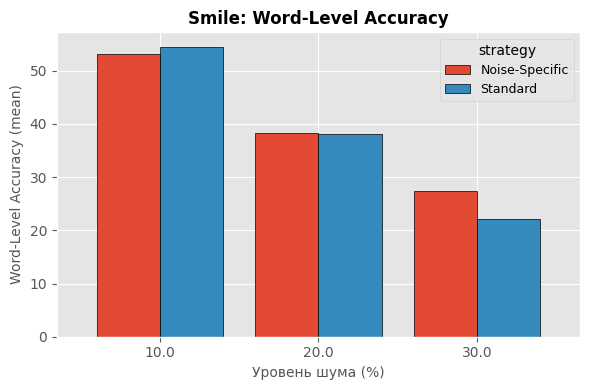

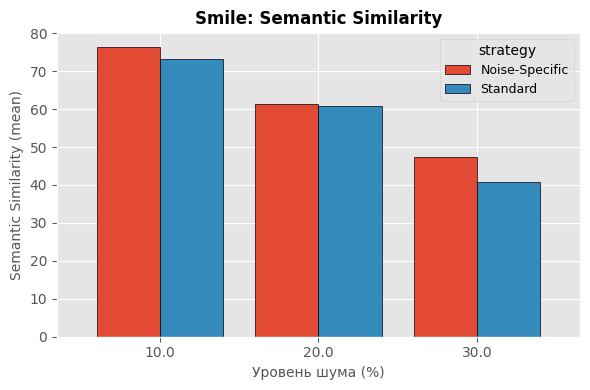

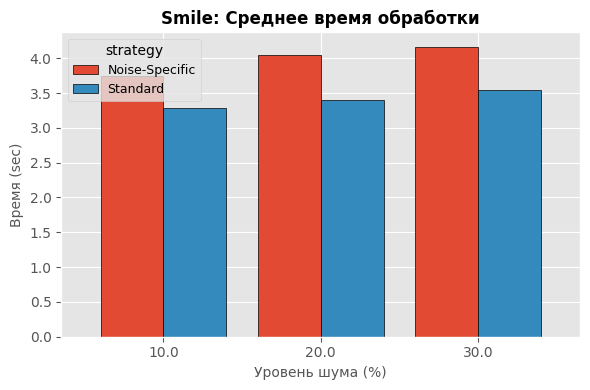

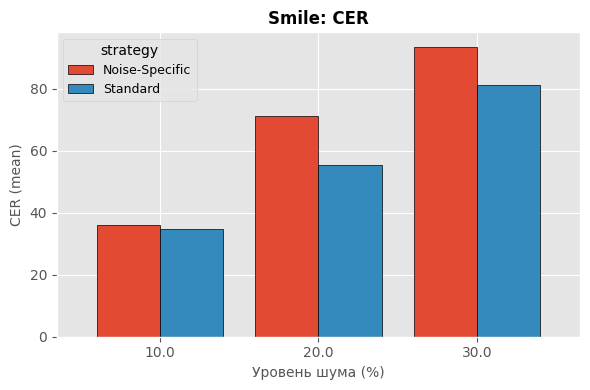

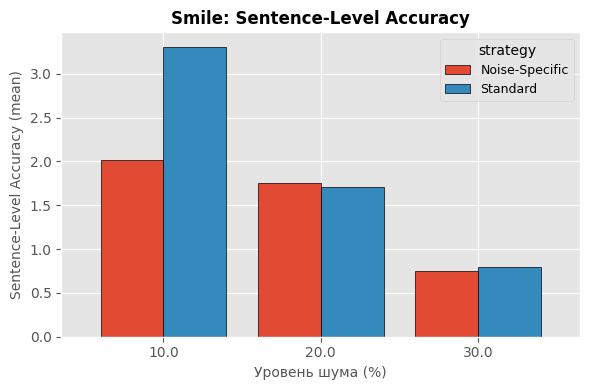

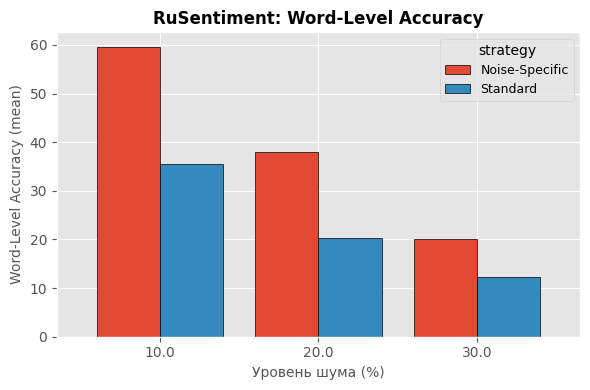

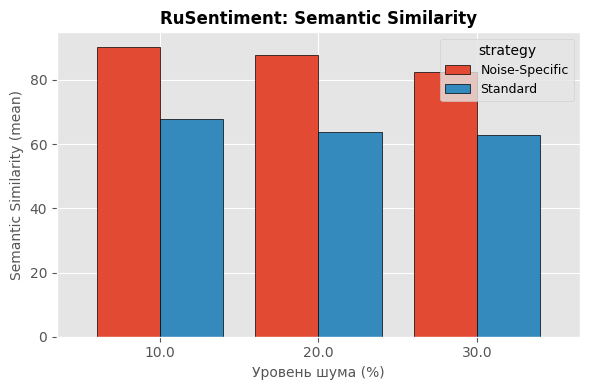

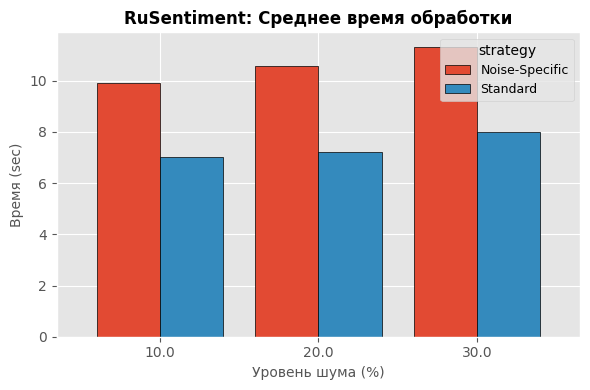

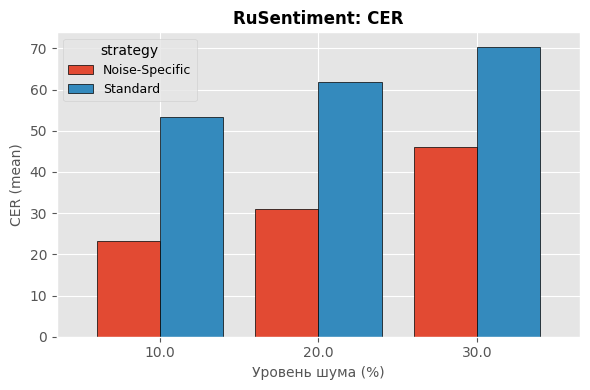

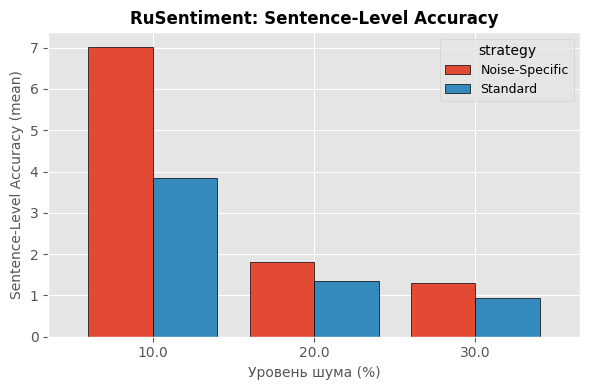

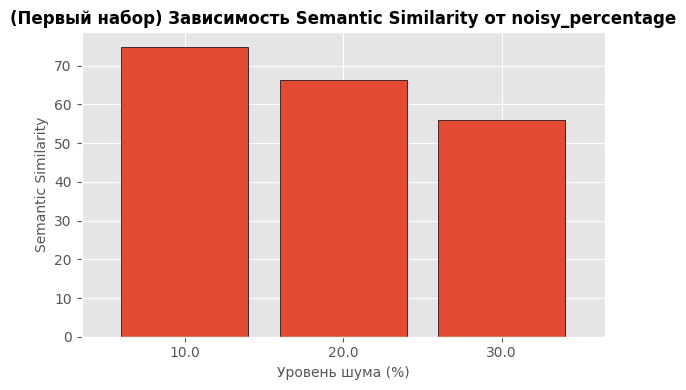

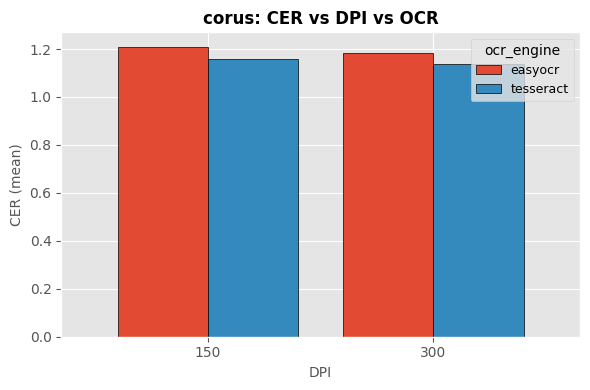

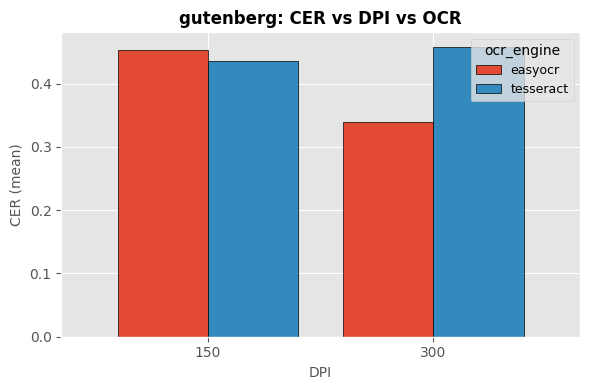

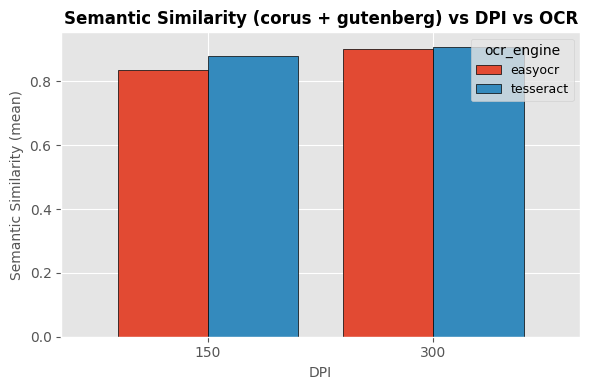

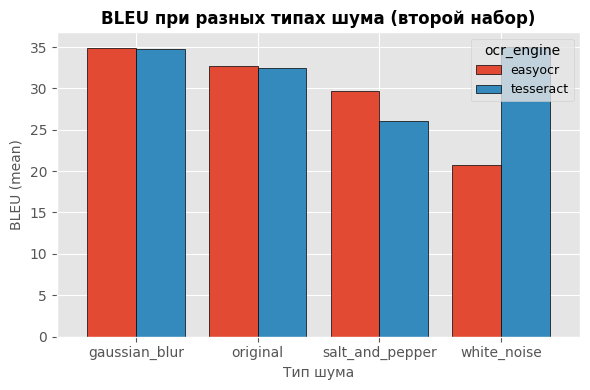

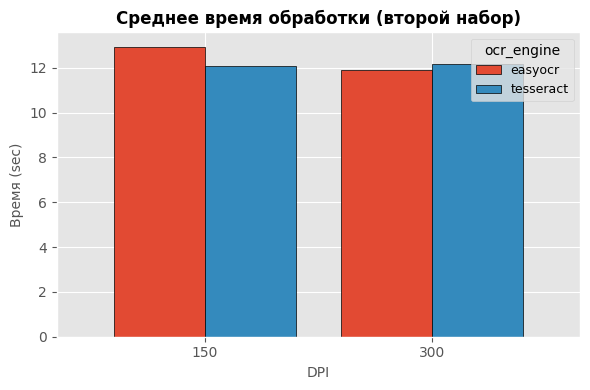

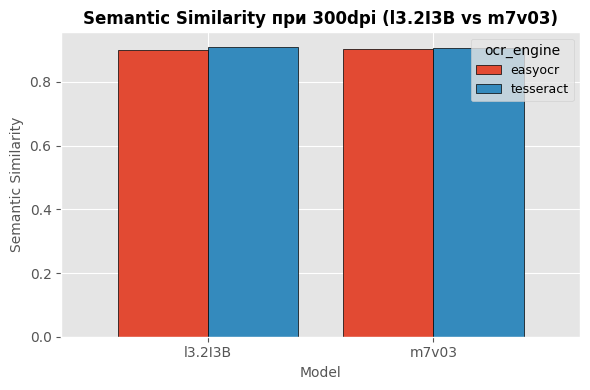

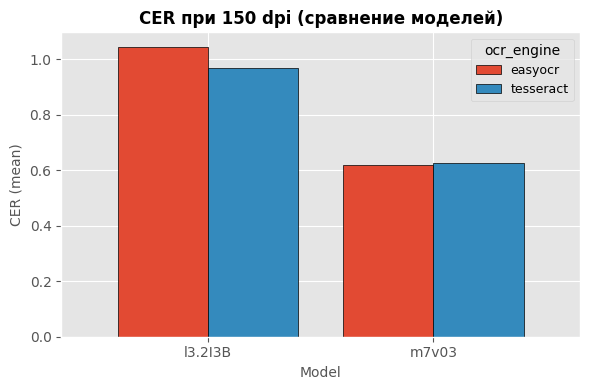

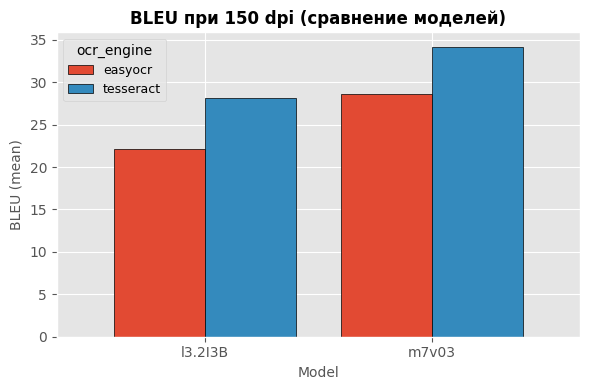

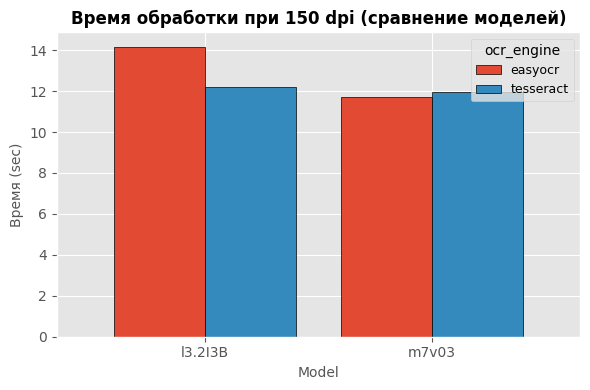

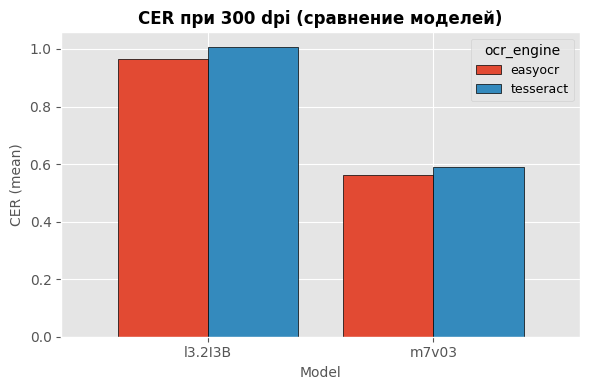

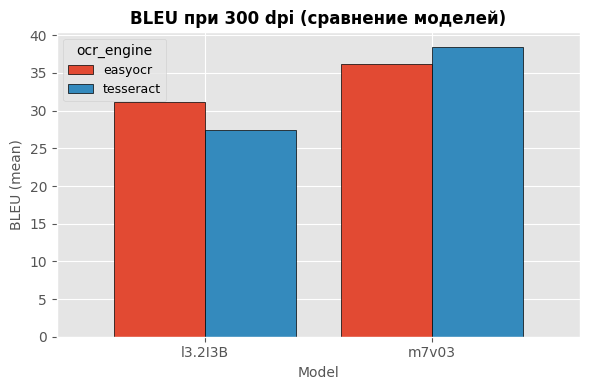

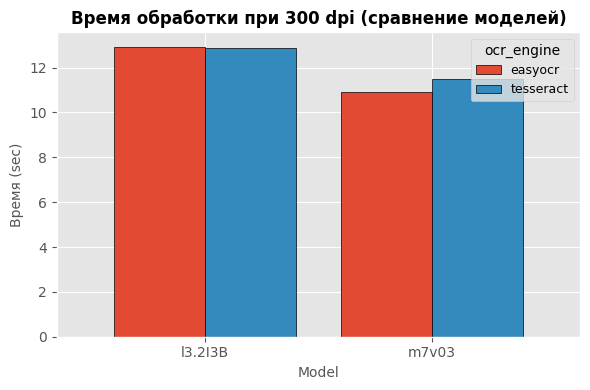

[plot_bar_chart] WARNING: Grouped data is empty for (Второй набор) Зависимость Semantic Similarity от OCR_percentage — skipping.


In [26]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # Или другой стиль

def load_first_dataset(json_folder: str) -> pd.DataFrame:
    """
    Читает JSON-файлы первого набора (Smile, RuSentiment).
    Возвращает DataFrame со столбцами:
      ['dataset_name', 'noise_percentage', 'strategy', 'CER', 'word_level_accuracy',
       'sentence_level_accuracy', 'semantic_similarity', 'elapsed_time', ...]
    """
    records = []
    for fname in os.listdir(json_folder):
        if not fname.endswith('.json'):
            continue
        
        full_path = os.path.join(json_folder, fname)
        with open(full_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # Предполагаем, что data — список словарей
            for row in data:
                dataset_name = row.get('dataset_name', 'Unknown')
                noise_perc = row.get('noise_percentage')  # int или float
                strategy = row.get('strategy', 'Unknown')
                
                cer = row.get('CER', None)
                w_acc = row.get('word_level_accuracy', None)
                s_acc = row.get('sentence_level_accuracy', None)
                sem_sim = row.get('semantic_similarity', None)
                time_ = row.get('elapsed_time', None)

                records.append({
                    'dataset_name': dataset_name,
                    'noise_percentage': noise_perc,
                    'strategy': strategy,
                    'CER': cer,
                    'word_level_accuracy': w_acc,
                    'sentence_level_accuracy': s_acc,
                    'semantic_similarity': sem_sim,
                    'elapsed_time': time_
                })
    
    df = pd.DataFrame(records)
    # Фильтр по уровням шума 10, 20, 30
    df = df[df['noise_percentage'].isin([10, 20, 30])]
    # Фильтр по датасетам
    df = df[df['dataset_name'].isin(['Smile', 'RuSentiment'])]
    return df


def load_second_dataset(json_folder: str) -> pd.DataFrame:
    """
    Читает JSON-файлы второго набора (corus, gutenberg).
    Возвращает DataFrame, где каждая запись соответствует:
      - Либо ocr_tesseract, либо ocr_easyocr, либо обе (если были в файле).
    Столбцы:
      ['dataset_name', 'dpi', 'ocr_engine', 'noise_type', 'ocr_percentage',
       'CER', 'BLEU', 'semantic_similarity', 'elapsed_time', 'model_name']
    """
    records = []
    for fname in os.listdir(json_folder):
        if not fname.endswith('.json'):
            continue
        
        full_path = os.path.join(json_folder, fname)
        with open(full_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # Предполагаем, что data — список словарей
            for row in data:
                pdf_name = row.get('pdf_name', '')
                if 'gutenberg' in pdf_name.lower():
                    dataset_name = 'gutenberg'
                elif 'corus' in pdf_name.lower():
                    dataset_name = 'corus'
                else:
                    dataset_name = 'Unknown'
                
                quality = row.get('quality', '0 dpi')
                dpi_str = quality.split()[0] if quality else '0'
                try:
                    dpi_val = int(dpi_str)
                except ValueError:
                    dpi_val = 0
                
                ocr_percentage = row.get('ocr_percentage', None)
                noise_type = row.get('noise_type', 'original')

                # Определяем модель
                if 'l3.2I3B' in fname:
                    model_name = 'l3.2I3B'
                elif 'm7v03' in fname or 'm7bv03' in fname:
                    model_name = 'm7v03'
                else:
                    model_name = 'UnknownModel'

                # Если и 'ocr_tesseract' и 'ocr_easyocr' в одном JSON, создаём две записи:
                # 1) OCR = tesseract
                if 'ocr_tesseract' in row:
                    rec_tess = {
                        'dataset_name': dataset_name,
                        'dpi': dpi_val,
                        'ocr_engine': 'tesseract',
                        'noise_type': noise_type,
                        'ocr_percentage': ocr_percentage,
                        'CER': row['ocr_tesseract'].get('CER'),
                        'BLEU': row['ocr_tesseract'].get('BLEU'),
                        'semantic_similarity': row['ocr_tesseract'].get('semantic_similarity'),
                        'elapsed_time': row['ocr_tesseract'].get('elapsed_time'),
                        'model_name': model_name
                    }
                    records.append(rec_tess)

                # 2) OCR = easyocr
                if 'ocr_easyocr' in row:
                    rec_easy = {
                        'dataset_name': dataset_name,
                        'dpi': dpi_val,
                        'ocr_engine': 'easyocr',
                        'noise_type': noise_type,
                        'ocr_percentage': ocr_percentage,
                        'CER': row['ocr_easyocr'].get('CER'),
                        'BLEU': row['ocr_easyocr'].get('BLEU'),
                        'semantic_similarity': row['ocr_easyocr'].get('semantic_similarity'),
                        'elapsed_time': row['ocr_easyocr'].get('elapsed_time'),
                        'model_name': model_name
                    }
                    records.append(rec_easy)

                # Если в файле не было вообще OCR-ключей, запись не добавится

    df = pd.DataFrame(records)
    # Фильтруем только нужные dpi (150, 300)
    df = df[df['dpi'].isin([150, 300])]
    # Фильтруем только нужные датасеты
    df = df[df['dataset_name'].isin(['corus', 'gutenberg'])]
    return df


def plot_bar_chart(df, x_col, y_col, hue_col=None, title='', x_label='', y_label=''):
    """
    Универсальная функция построения столбчатой диаграммы.
    df      : pandas.DataFrame
    x_col   : Название столбца, по которому группируем по оси X
    y_col   : Название столбца, значение которого выводим по оси Y
    hue_col : Если задан, то будет создавать группу столбиков разного цвета (legend)
    """
    if df.empty:
        print(f"[plot_bar_chart] WARNING: DataFrame is empty for {title} — skipping.")
        return
    
    # Убираем NaN из y_col, иначе могут быть ошибки
    df = df.dropna(subset=[y_col])
    
    if df.empty:
        print(f"[plot_bar_chart] WARNING: No valid data (NaN in {y_col}) for {title} — skipping.")
        return
    
    if hue_col:
        grouped = df.groupby([x_col, hue_col])[y_col].mean().unstack(hue_col)
    else:
        grouped = df.groupby(x_col)[y_col].mean()

    if grouped.empty:
        print(f"[plot_bar_chart] WARNING: Grouped data is empty for {title} — skipping.")
        return
    
    ax = grouped.plot(
        kind='bar',
        figsize=(6, 4),
        width=0.8,
        edgecolor='black'
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    plt.xticks(rotation=0)
    
    if hue_col:
        plt.legend(title=hue_col, fontsize=9)
    else:
        plt.legend().remove()
    
    plt.tight_layout()
    plt.show()


def main():
    first_data_folder = 'outputs/first'
    second_data_folder = 'outputs/second'

    # 1) Загружаем первый набор
    df_first = load_first_dataset(first_data_folder)
    # 2) Загружаем второй набор
    df_second = load_second_dataset(second_data_folder)

    # =========================
    # ПЕРВЫЙ НАБОР (Smile, RuSentiment)
    # =========================
    # A) Существующие графики (word_level_accuracy, semantic_similarity, elapsed_time и т.д.) vs noise_percentage
    for dataset_name in ['Smile', 'RuSentiment']:
        tmp = df_first[df_first['dataset_name'] == dataset_name]
        if len(tmp) == 0:
            continue

        # 1. Word-Level Accuracy
        plot_bar_chart(
            tmp,
            x_col='noise_percentage',
            y_col='word_level_accuracy',
            hue_col='strategy',
            title=f"{dataset_name}: Word-Level Accuracy",
            x_label="Уровень шума (%)",
            y_label="Word-Level Accuracy (mean)"
        )

        # 2. Semantic Similarity
        plot_bar_chart(
            tmp,
            x_col='noise_percentage',
            y_col='semantic_similarity',
            hue_col='strategy',
            title=f"{dataset_name}: Semantic Similarity",
            x_label="Уровень шума (%)",
            y_label="Semantic Similarity (mean)"
        )

        # 3. Время
        plot_bar_chart(
            tmp,
            x_col='noise_percentage',
            y_col='elapsed_time',
            hue_col='strategy',
            title=f"{dataset_name}: Среднее время обработки",
            x_label="Уровень шума (%)",
            y_label="Время (sec)"
        )

        # 4. CER (дополнительно)
        if 'CER' in tmp.columns:
            plot_bar_chart(
                tmp,
                x_col='noise_percentage',
                y_col='CER',
                hue_col='strategy',
                title=f"{dataset_name}: CER",
                x_label="Уровень шума (%)",
                y_label="CER (mean)"
            )

        # 5. Sentence-Level Accuracy (дополнительно)
        if 'sentence_level_accuracy' in tmp.columns:
            plot_bar_chart(
                tmp,
                x_col='noise_percentage',
                y_col='sentence_level_accuracy',
                hue_col='strategy',
                title=f"{dataset_name}: Sentence-Level Accuracy",
                x_label="Уровень шума (%)",
                y_label="Sentence-Level Accuracy (mean)"
            )

    # B) График сравнения baseline (noisy_percentage) и semantic_similarity:
    #    Здесь по оси X = noisy_percentage, по оси Y = semantic_similarity (без hue).
    #    Или можно добавить hue_col='strategy'.
    if not df_first.empty:
        plot_bar_chart(
            df_first,
            x_col='noise_percentage',
            y_col='semantic_similarity',
            hue_col=None,  # Или 'strategy', если хотите
            title="(Первый набор) Зависимость Semantic Similarity от noisy_percentage",
            x_label="Уровень шума (%)",
            y_label="Semantic Similarity"
        )

    # =========================
    # ВТОРОЙ НАБОР (corus, gutenberg)
    # =========================
    # A) Уже существующие графики
    # 1. CER vs DPI vs ocr_engine (раздельно для corus/gutenberg)
    for dataset_name in ['corus', 'gutenberg']:
        tmp = df_second[df_second['dataset_name'] == dataset_name]
        plot_bar_chart(
            tmp,
            x_col='dpi',
            y_col='CER',
            hue_col='ocr_engine',
            title=f"{dataset_name}: CER vs DPI vs OCR",
            x_label="DPI",
            y_label="CER (mean)"
        )

    # 2. Semantic similarity vs dpi vs ocr_engine (объединённо)
    plot_bar_chart(
        df_second,
        x_col='dpi',
        y_col='semantic_similarity',
        hue_col='ocr_engine',
        title="Semantic Similarity (corus + gutenberg) vs DPI vs OCR",
        x_label="DPI",
        y_label="Semantic Similarity (mean)"
    )

    # 3. BLEU vs noise_type vs ocr_engine (если есть noise_type)
    if 'noise_type' in df_second.columns and 'BLEU' in df_second.columns:
        plot_bar_chart(
            df_second,
            x_col='noise_type',
            y_col='BLEU',
            hue_col='ocr_engine',
            title="BLEU при разных типах шума (второй набор)",
            x_label="Тип шума",
            y_label="BLEU (mean)"
        )

    # 4. Время vs dpi vs ocr_engine
    plot_bar_chart(
        df_second,
        x_col='dpi',
        y_col='elapsed_time',
        hue_col='ocr_engine',
        title="Среднее время обработки (второй набор)",
        x_label="DPI",
        y_label="Время (sec)"
    )

    # 5. Сравнение моделей (l3.2I3B vs m7v03) при 300 dpi
    tmp_300 = df_second[df_second['dpi'] == 300]
    if not tmp_300.empty:
        plot_bar_chart(
            tmp_300,
            x_col='model_name',
            y_col='semantic_similarity',
            hue_col='ocr_engine',
            title="Semantic Similarity при 300dpi (l3.2I3B vs m7v03)",
            x_label="Model",
            y_label="Semantic Similarity"
        )

    # B) Дополнительные графики (CER vs model_name, BLEU vs model_name, elapsed_time vs model_name...)
    for dpi_val in [150, 300]:
        tmp_dpi = df_second[df_second['dpi'] == dpi_val]

        # CER vs model_name
        plot_bar_chart(
            tmp_dpi,
            x_col='model_name',
            y_col='CER',
            hue_col='ocr_engine',
            title=f"CER при {dpi_val} dpi (сравнение моделей)",
            x_label="Model",
            y_label="CER (mean)"
        )

        # BLEU vs model_name
        if 'BLEU' in tmp_dpi.columns:
            plot_bar_chart(
                tmp_dpi,
                x_col='model_name',
                y_col='BLEU',
                hue_col='ocr_engine',
                title=f"BLEU при {dpi_val} dpi (сравнение моделей)",
                x_label="Model",
                y_label="BLEU (mean)"
            )

        # elapsed_time vs model_name
        plot_bar_chart(
            tmp_dpi,
            x_col='model_name',
            y_col='elapsed_time',
            hue_col='ocr_engine',
            title=f"Время обработки при {dpi_val} dpi (сравнение моделей)",
            x_label="Model",
            y_label="Время (sec)"
        )

    # C) График сравнения baseline (ocr_percentage) и semantic_similarity:
    #    Здесь по оси X = ocr_percentage, по оси Y = semantic_similarity.
    #    Можно добавить hue_col='ocr_engine' или 'model_name'.
    if not df_second.empty and 'ocr_percentage' in df_second.columns:
        plot_bar_chart(
            df_second,
            x_col='ocr_percentage',
            y_col='semantic_similarity',
            hue_col='ocr_engine',  # или model_name, или None
            title="(Второй набор) Зависимость Semantic Similarity от OCR_percentage",
            x_label="OCR Percentage (baseline accuracy)",
            y_label="Semantic Similarity"
        )


if __name__ == '__main__':
    main()


In [7]:
import json
import numpy as np

# Функция для обработки файлов из папки 'first'
def process_first_files(file_paths):
    grouped_data = {}

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for entry in data:
            language = entry.get("original_language")
            noise_level = entry.get("noise_percentage")

            if language is None or noise_level is None:
                continue

            # Создаем структуру для хранения данных
            if language not in grouped_data:
                grouped_data[language] = {}
            if noise_level not in grouped_data[language]:
                grouped_data[language][noise_level] = {
                    "word_level_accuracy": [],
                    "semantic_similarity": []
                }

            wla_value = entry.get("word_level_accuracy", 0)
            ss_value = entry.get("semantic_similarity", 0)

            # Фильтрация значений ниже 50%
            if wla_value >= 70:
                grouped_data[language][noise_level]["word_level_accuracy"].append(wla_value)
            if ss_value >= 70:
                grouped_data[language][noise_level]["semantic_similarity"].append(ss_value)

    # Рассчитываем средние значения
    averaged_data = {}
    for language, noise_groups in grouped_data.items():
        averaged_data[language] = {}
        for noise_level, metrics in noise_groups.items():
            avg_wla = np.mean(metrics["word_level_accuracy"]) if metrics["word_level_accuracy"] else 0
            avg_ss = np.mean(metrics["semantic_similarity"]) if metrics["semantic_similarity"] else 0

            averaged_data[language][noise_level] = {
                "average_word_level_accuracy": avg_wla,
                "average_semantic_similarity": avg_ss
            }

    return averaged_data

# Указываем пути к файлам из папки 'first'
file_paths_first = [
    "outputs/first/l3.2I3B_Standard_normalized_fixed.json",
    "outputs/first/m7v03_Standard_normalized_fixed.json"
]

# Обрабатываем файлы и получаем результаты
results_first = process_first_files(file_paths_first)

# Сохраняем результаты в JSON-файл
with open("results_first.json", "w", encoding="utf-8") as f:
    json.dump(results_first, f, ensure_ascii=False, indent=4)

# Выводим результаты в консоль
for language, noise_groups in results_first.items():
    print(f"Language: {language}")
    for noise_level, metrics in noise_groups.items():
        print(f"  Noise Level: {noise_level}%")
        print(f"    Average WLA: {metrics['average_word_level_accuracy']:.2f}")
        print(f"    Average Semantic Similarity: {metrics['average_semantic_similarity']:.2f}")


Language: English
  Noise Level: 10.0%
    Average WLA: 75.94
    Average Semantic Similarity: 84.22
  Noise Level: 20.0%
    Average WLA: 75.40
    Average Semantic Similarity: 78.42
  Noise Level: 30.0%
    Average WLA: 0.00
    Average Semantic Similarity: 74.54
Language: Russian
  Noise Level: 10.0%
    Average WLA: 73.95
    Average Semantic Similarity: 93.15
  Noise Level: 20.0%
    Average WLA: 0.00
    Average Semantic Similarity: 88.67
  Noise Level: 30.0%
    Average WLA: 0.00
    Average Semantic Similarity: 85.89


In [71]:
import json
import numpy as np

# Функция для обработки файлов из папки 'second'
def process_second_files(file_paths):
    grouped_data = {}

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for entry in data:
            language = entry.get("language")
            quality = entry.get("quality")

            if language is None or quality is None:
                continue

            for ocr_key in ["ocr_tesseract", "ocr_easyocr"]:
                ocr_data = entry.get(ocr_key)
                if ocr_data is None:
                    continue

                # Создаем структуру для хранения данных
                if language not in grouped_data:
                    grouped_data[language] = {}
                if quality not in grouped_data[language]:
                    grouped_data[language][quality] = {}
                if ocr_key not in grouped_data[language][quality]:
                    grouped_data[language][quality][ocr_key] = {
                        "word_level_accuracy": [],
                        "semantic_similarity": [],
                        "ocr_percentage": []
                    }

                # Фильтрация значений ниже 50%
                wla_value = ocr_data.get("word_level_accuracy", 0)
                ss_value = ocr_data.get("semantic_similarity", 0)
                ocr_percentage_value = ocr_data.get("ocr_percentage", 0)

                if wla_value >= 0.7:
                    grouped_data[language][quality][ocr_key]["word_level_accuracy"].append(wla_value)
                if ss_value >= 0.8:
                    grouped_data[language][quality][ocr_key]["semantic_similarity"].append(ss_value)
                if ocr_percentage_value > 0:  # Учитываем все значения ocr_percentage
                    grouped_data[language][quality][ocr_key]["ocr_percentage"].append(ocr_percentage_value)

    # Рассчитываем средние значения
    averaged_data = {}
    for language, quality_groups in grouped_data.items():
        averaged_data[language] = {}
        for quality, ocr_groups in quality_groups.items():
            averaged_data[language][quality] = {}
            for ocr_key, metrics in ocr_groups.items():
                avg_wla = np.mean(metrics["word_level_accuracy"]) if metrics["word_level_accuracy"] else 0
                avg_ss = np.mean(metrics["semantic_similarity"]) if metrics["semantic_similarity"] else 0
                avg_ocr_percentage = np.mean(metrics["ocr_percentage"]) if metrics["ocr_percentage"] else 0

                averaged_data[language][quality][ocr_key] = {
                    "average_word_level_accuracy": avg_wla,
                    "average_semantic_similarity": avg_ss,
                    "average_ocr_percentage": avg_ocr_percentage
                }

    return averaged_data

# Указываем пути к файлам из папки 'second'
file_paths_second = [
    "outputs/second/l3.2I3B_Error-specific_normalized_DS2.json",
    "outputs/second/m7v03_Error-specific_normalized_DS2.json"
]

# Обрабатываем файлы и получаем результаты
results_second = process_second_files(file_paths_second)

# Сохраняем результаты в JSON-файл
with open("results_second.json", "w", encoding="utf-8") as f:
    json.dump(results_second, f, ensure_ascii=False, indent=4)

# Выводим результаты в консоль
for language, quality_groups in results_second.items():
    print(f"Language: {language}")
    for quality, ocr_groups in quality_groups.items():
        print(f"  Quality: {quality}")
        for ocr_key, metrics in ocr_groups.items():
            print(f"    OCR Method: {ocr_key}")
            print(f"      Average WLA: {metrics['average_word_level_accuracy']:.2f}")
            print(f"      Average Semantic Similarity: {metrics['average_semantic_similarity']:.2f}")
            print(f"      OCR Percentage (Before Normalization): {metrics['average_ocr_percentage']:.2f}")


Language: English
  Quality: 300 dpi
    OCR Method: ocr_tesseract
      Average WLA: 0.91
      Average Semantic Similarity: 0.95
      OCR Percentage (Before Normalization): 0.95
    OCR Method: ocr_easyocr
      Average WLA: 0.86
      Average Semantic Similarity: 0.94
      OCR Percentage (Before Normalization): 0.95
  Quality: 150 dpi
    OCR Method: ocr_tesseract
      Average WLA: 0.90
      Average Semantic Similarity: 0.94
      OCR Percentage (Before Normalization): 0.92
    OCR Method: ocr_easyocr
      Average WLA: 0.85
      Average Semantic Similarity: 0.92
      OCR Percentage (Before Normalization): 0.87
Language: Russian
  Quality: 300 dpi
    OCR Method: ocr_tesseract
      Average WLA: 0.00
      Average Semantic Similarity: 0.89
      OCR Percentage (Before Normalization): 0.95
    OCR Method: ocr_easyocr
      Average WLA: 0.86
      Average Semantic Similarity: 0.90
      OCR Percentage (Before Normalization): 0.96
  Quality: 150 dpi
    OCR Method: ocr_tesseract


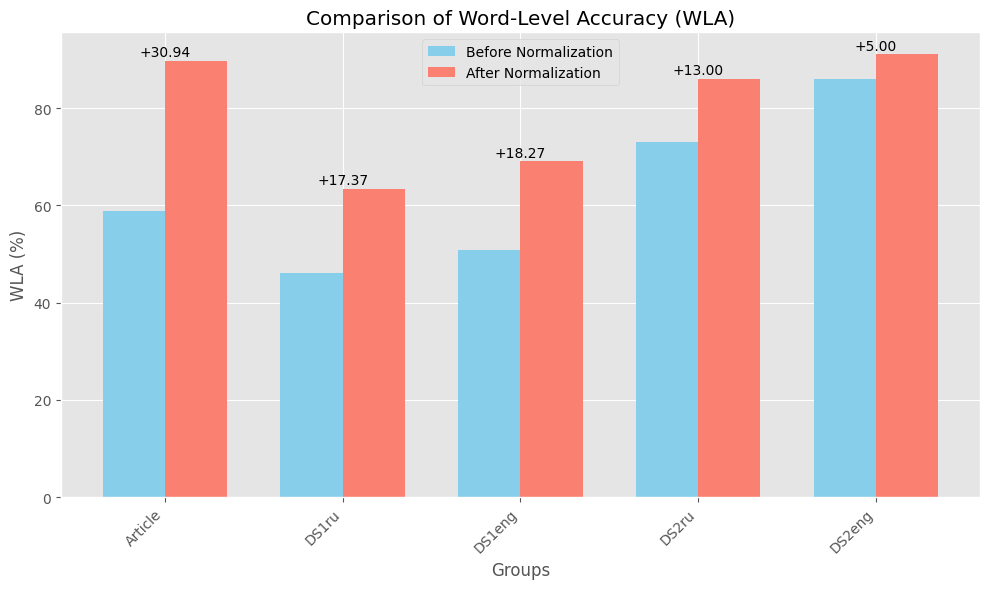

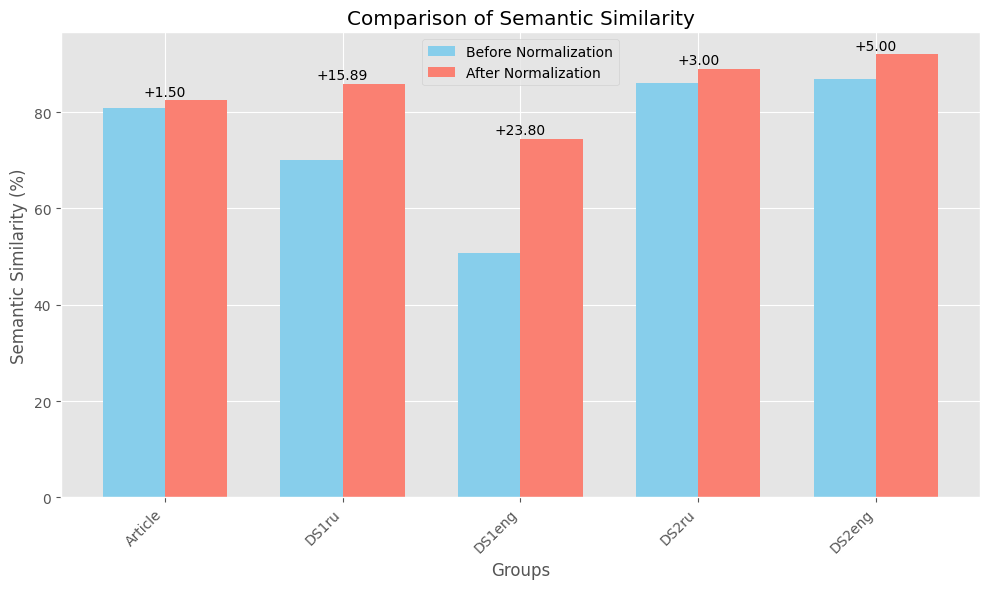

In [73]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Данные из статьи
article_data = {
    "WLA": {
        "Before": 58.78,
        "After": 89.72
    },
    "Semantic": {
        "Before": 80.97,
        "After": 82.47
    }
}

# Данные из DS1 и DS2
user_data = {
    "WLA": {
        "Before": [58.78, 46.0, 50.74, 73.0, 86.0],
        "After": [89.72, 63.37, 69.01, 86.0, 91.0]
    },
    "Semantic": {
        "Before": [80.97, 70.0, 50.74, 86.0, 87.0],
        "After": [82.47, 85.89, 74.54, 89.0, 92.0]
    }
}

# Функция для построения графиков
def plot_comparison(user_data, metric, title, ylabel, filename):
    groups = ["Article", "DS1ru", "DS1eng", "DS2ru", "DS2eng"]
    x = np.arange(len(groups))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # Данные для графика
    before_values = user_data[metric]["Before"]
    after_values = user_data[metric]["After"]

    # Построение столбцов
    bars_before = ax.bar(x - bar_width / 2, before_values, bar_width, label="Before Normalization", color="skyblue")
    bars_after = ax.bar(x + bar_width / 2, after_values, bar_width, label="After Normalization", color="salmon")

    # Отображение разницы между столбцами
    for i in range(len(bars_before)):
        diff = after_values[i] - before_values[i]
        ax.text(
            x[i],
            max(before_values[i], after_values[i]) + 1,
            f"+{diff:.2f}" if diff >= 0 else f"{diff:.2f}",
            ha="center",
            fontsize=10,
            color="black"
        )

    # Настройки графика
    ax.set_xlabel("Groups")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Построение графиков
plot_comparison(
    user_data,
    metric="WLA",
    title="Comparison of Word-Level Accuracy (WLA)",
    ylabel="WLA (%)",
    filename="wla_comparison_updated.png"
)

plot_comparison(
    user_data,
    metric="Semantic",
    title="Comparison of Semantic Similarity",
    ylabel="Semantic Similarity (%)",
    filename="semantic_comparison_updated.png"
)


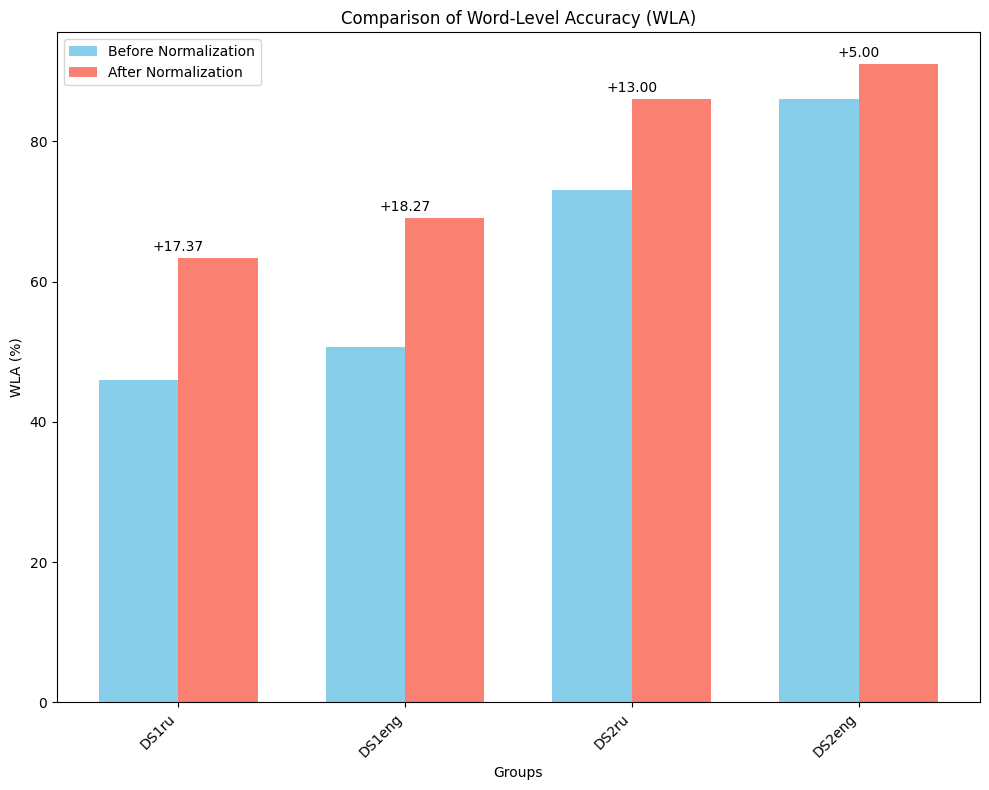

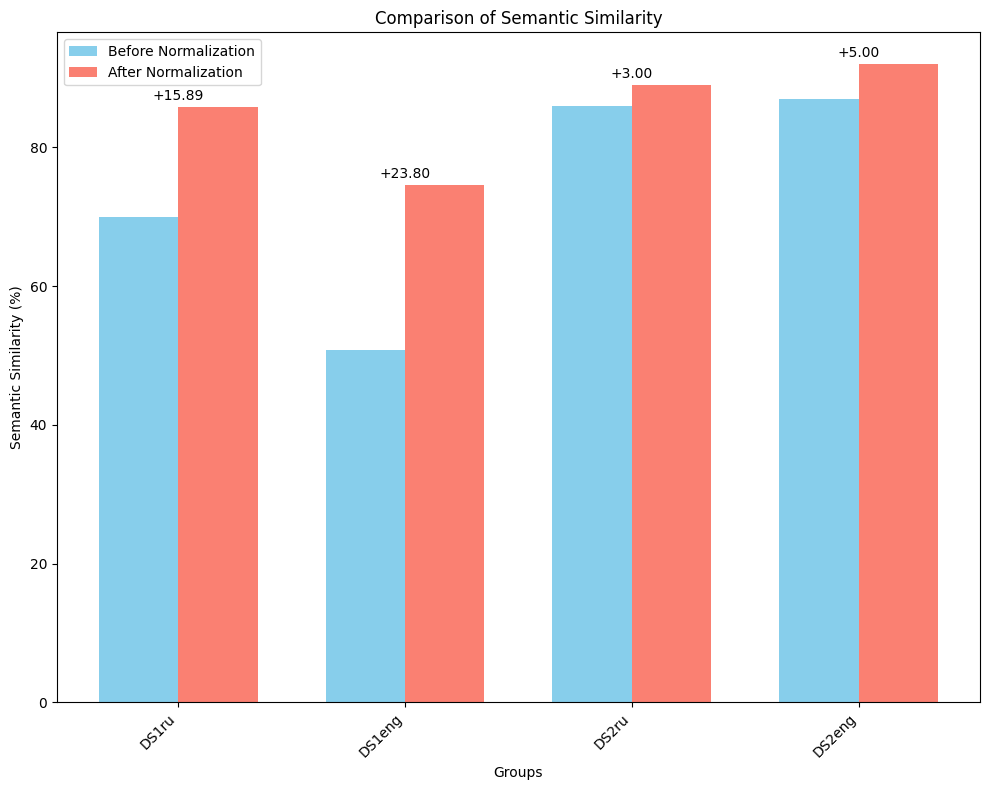

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Данные из статьи
article_data = {
    "WLA": {
        "Before": 58.78,
        "After": 89.72
    },
    "Semantic": {
        "Before": 80.97,
        "After": 82.47
    }
}

# Данные из DS1 и DS2
user_data = {
    "WLA": {
        "Before": [46.0, 50.74, 73.0, 86.0],
        "After": [63.37, 69.01, 86.0, 91.0]
    },
    "Semantic": {
        "Before": [70.0, 50.74, 86.0, 87.0],
        "After": [85.89, 74.54, 89.0, 92.0]
    }
}

# Функция для построения графиков
def plot_comparison(user_data, metric, title, ylabel, filename):
    groups = ["DS1ru", "DS1eng", "DS2ru", "DS2eng"]
    x = np.arange(len(groups))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 8))

    # Данные для графика
    before_values = user_data[metric]["Before"]
    after_values = user_data[metric]["After"]

    # Построение столбцов
    bars_before = ax.bar(x - bar_width / 2, before_values, bar_width, label="Before Normalization", color="skyblue")
    bars_after = ax.bar(x + bar_width / 2, after_values, bar_width, label="After Normalization", color="salmon")

    # Отображение разницы между столбцами
    for i in range(len(bars_before)):
        diff = after_values[i] - before_values[i]
        ax.text(
            x[i],
            max(before_values[i], after_values[i]) + 1,
            f"+{diff:.2f}" if diff >= 0 else f"{diff:.2f}",
            ha="center",
            fontsize=10,
            color="black"
        )

    # Настройки графика
    ax.set_xlabel("Groups")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Построение графиков
plot_comparison(
    user_data,
    metric="WLA",
    title="Comparison of Word-Level Accuracy (WLA)",
    ylabel="WLA (%)",
    filename="wla_comparison_updated.png"
)

plot_comparison(
    user_data,
    metric="Semantic",
    title="Comparison of Semantic Similarity",
    ylabel="Semantic Similarity (%)",
    filename="semantic_comparison_updated.png"
)

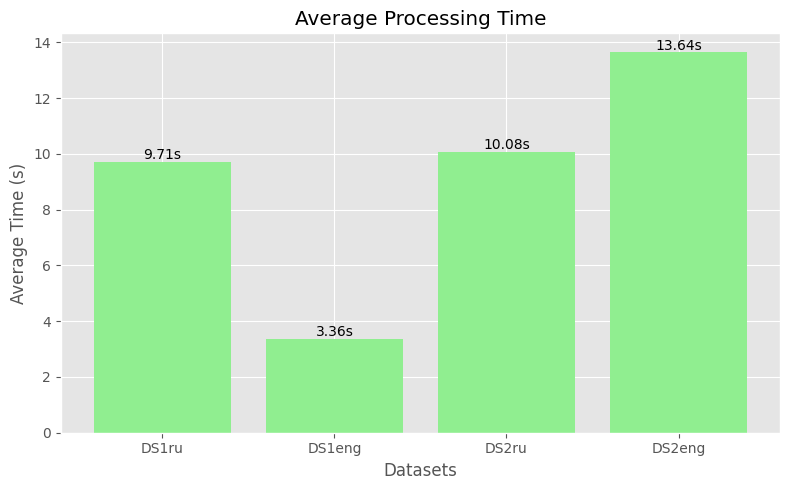

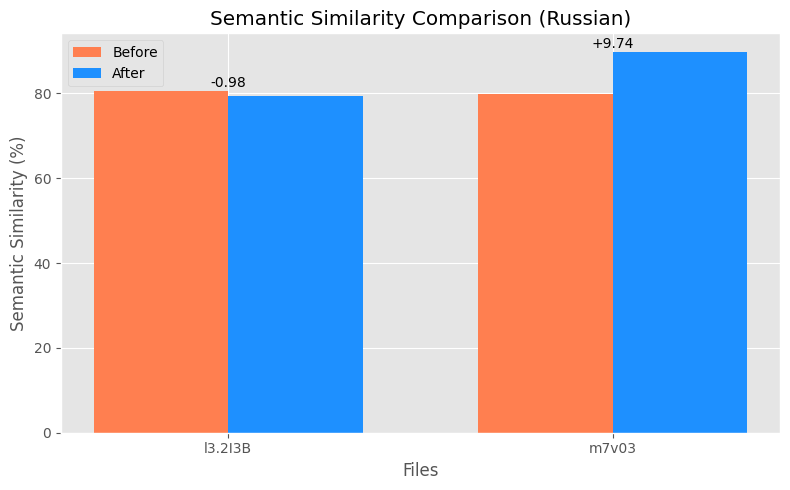

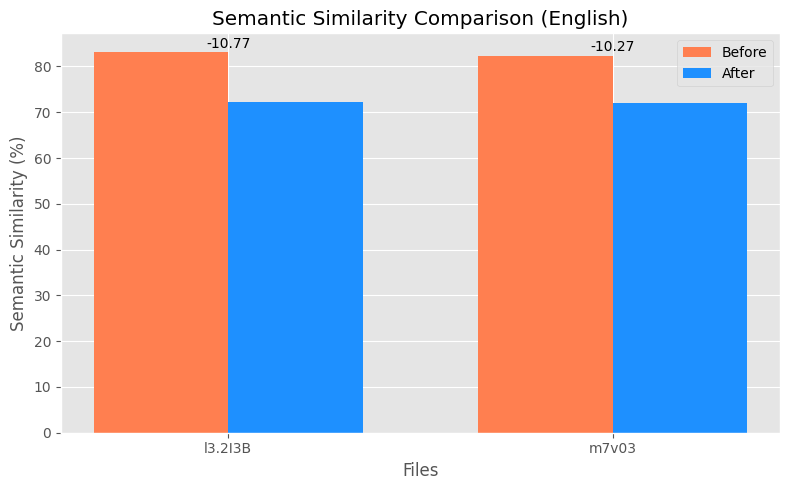

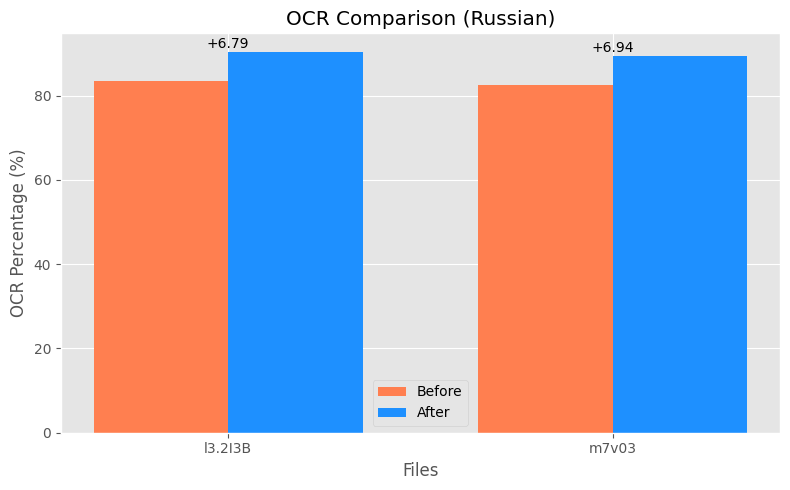

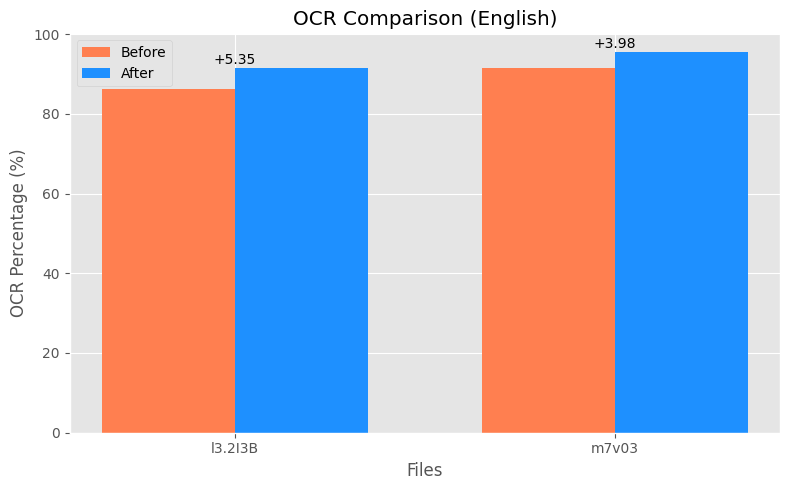

In [95]:
import json
import numpy as np
import matplotlib.pyplot as plt

# ------------------------ Утилита для проверки/приведения к процентам ------------------------ #

def ensure_percent(value):
    """
    Утилитарная функция, которая проверяет:
      - Если value находится в диапазоне (0, 1], считаем, что это доля, и умножаем на 100.
      - Если value > 1, предполагаем, что это уже проценты.
    """
    if 0 < value <= 1:
        return value * 100
    else:
        return value

# ------------------------ Функции обработки файлов ------------------------ #

def process_first_files(file_paths):
    """
    Обрабатывает файлы из папки 'first'.
    ДОПОЛНИТЕЛЬНО: берём ТОЛЬКО те записи, у которых semantic_similarity > 50%.
    """
    grouped_data = {}

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for entry in data:
            language = entry.get("original_language")
            noise_level = entry.get("noise_percentage")

            wla_value = entry.get("word_level_accuracy", 0)
            ss_value = entry.get("semantic_similarity", 0)
            elapsed_time = entry.get("elapsed_time", 0)

            # Пропускаем, если язык не указан или noise_level отсутствует
            if language is None or noise_level is None:
                continue

            # Приводим к процентам
            noise_level = ensure_percent(noise_level)
            wla_value   = ensure_percent(wla_value)
            ss_value    = ensure_percent(ss_value)

            # Фильтр: semantic_similarity > 50
            if ss_value <= 50:
                continue

            # Инициализируем словарь для данного языка
            if language not in grouped_data:
                grouped_data[language] = {
                    "l3.2I3B": [],
                    "m7v03": []
                }

            # Определяем, к какой группе (файлу) относится запись
            group_key = "l3.2I3B" if "l3.2I3B" in file_path else "m7v03"

            grouped_data[language][group_key].append({
                "noise_percentage": noise_level,
                "semantic_similarity": ss_value,
                "word_level_accuracy": wla_value,
                "elapsed_time": elapsed_time
            })

    return grouped_data


def process_second_files(file_paths):
    """
    Обрабатывает файлы из папки 'second'.
    Сохраняем ТОЛЬКО те записи, где 'semantic_similarity' > 'ocr_percentage'.
    Предварительно приводим все значения к процентам.
    """
    grouped_data = {}

    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for entry in data:
            language = entry.get("language")
            quality = entry.get("quality")

            if language is None or quality is None:
                continue

            group_key = "l3.2I3B" if "l3.2I3B" in file_path else "m7v03"

            if language not in grouped_data:
                grouped_data[language] = {
                    "l3.2I3B": [],
                    "m7v03": []
                }

            ocr_data = entry.get("ocr_tesseract", {})
            if ocr_data:
                ss_value = ocr_data.get("semantic_similarity", 0)
                ocr_percentage_value = ocr_data.get("ocr_percentage", 0)
                elapsed_time = ocr_data.get("elapsed_time", 0)

                # Приводим к процентам
                ss_value = ensure_percent(ss_value)
                ocr_percentage_value = ensure_percent(ocr_percentage_value)

                # Фильтр: semantic_similarity > ocr_percentage
                if ss_value > ocr_percentage_value:
                    grouped_data[language][group_key].append({
                        "ocr_percentage": ocr_percentage_value,
                        "semantic_similarity": ss_value,
                        "elapsed_time": elapsed_time
                    })

    return grouped_data

# ------------------------ Функции построения графиков ------------------------ #

def plot_average_time(data, title, filename):
    """
    Столбиковая диаграмма среднего времени выполнения (elapsed_time).
    """
    groups = list(data.keys())
    averages = []

    for group in groups:
        # Собираем все записи из подгрупп
        entries = []
        for subgroup in data[group]:
            entries.extend(data[group][subgroup])
        
        if len(entries) > 0:
            avg_time = np.mean([e.get("elapsed_time", 0) for e in entries])
        else:
            avg_time = 0
        averages.append(avg_time)

    plt.figure(figsize=(8, 5))
    bars = plt.bar(groups, averages, color="lightgreen")
    
    # Пишем текст над столбцами
    for i, bar in enumerate(bars):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.1, 
            f"{averages[i]:.2f}s", 
            ha='center', fontsize=10
        )

    plt.xlabel("Datasets")
    plt.ylabel("Average Time (s)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


def plot_comparison(data, title, ylabel, filename, metric_key, baseline_key, is_percentage=False):
    """
    Сравнение двух групп (l3.2I3B и m7v03) по заданным ключам:
      - metric_key (например, 'semantic_similarity')
      - baseline_key (например, 'noise_percentage' или 'ocr_percentage')

    Логика:
      - Если baseline_key == "noise_percentage": 
            before = 100 - noise
        (как было в оригинале для шума)
      - Если baseline_key == "ocr_percentage": 
            before = ocr_percentage
        (без вычитания из 100!)
      - after = metric (если is_percentage=True, считаем, что это уже 0..100)
    """
    groups = ["l3.2I3B", "m7v03"]
    x = np.arange(len(groups))
    bar_width = 0.35

    before_vals = []
    after_vals = []

    for group in groups:
        group_entries = data.get(group, [])
        if not group_entries:
            before_vals.append(0)
            after_vals.append(0)
            continue

        # Собираем baseline-значения
        baseline_list = [e[baseline_key] for e in group_entries]
        # Собираем метрику
        metric_list   = [e[metric_key]   for e in group_entries]

        if baseline_key == "noise_percentage":
            # Для шума делаем 100 - noise
            bval = np.mean([100 - val for val in baseline_list])
        elif baseline_key == "ocr_percentage":
            # Для OCR берём напрямую
            bval = np.mean(baseline_list)
        else:
            # На всякий случай, если появится другой baseline
            bval = np.mean(baseline_list)

        if is_percentage:
            aval = np.mean(metric_list)  # У нас уже 0..100
        else:
            aval = np.mean(metric_list)

        before_vals.append(bval)
        after_vals.append(aval)

    fig, ax = plt.subplots(figsize=(8, 5))

    bars_before = ax.bar(x - bar_width / 2, before_vals, bar_width, 
                         label="Before", color="coral")
    bars_after  = ax.bar(x + bar_width / 2, after_vals,  bar_width, 
                         label="After",  color="dodgerblue")

    # Подписи разницы
    for i in range(len(bars_before)):
        diff = after_vals[i] - before_vals[i]
        ax.text(
            x[i],
            max(before_vals[i], after_vals[i]) + 1,
            f"{diff:+.2f}",
            ha="center",
            fontsize=10
        )

    ax.set_xlabel("Files")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# ------------------------ Основной блок ------------------------ #

if __name__ == "__main__":
    # Пути к "первому" набору
    file_paths_first = [
        "outputs/first/l3.2I3B_Standard_normalized_fixed.json",
        "outputs/first/m7v03_Standard_normalized_fixed.json"
    ]
    # Обрабатываем (только sim>50%)
    data_first = process_first_files(file_paths_first)

    # Пути ко "второму" набору
    file_paths_second = [
        "outputs/second/l3.2I3B_Error-specific_normalized_DS2.json",
        "outputs/second/m7v03_Error-specific_normalized_DS2.json"
    ]
    # Обрабатываем (sim>ocr)
    data_second = process_second_files(file_paths_second)

    # 1. Среднее время
    plot_average_time(
        {
            "DS1ru":  data_first.get("Russian", {}),
            "DS1eng": data_first.get("English", {}),
            "DS2ru":  data_second.get("Russian", {}),
            "DS2eng": data_second.get("English", {})
        },
        title="Average Processing Time",
        filename="average_time.png"
    )

    # 2. Сравнение Semantic Similarity для Russian (First)
    plot_comparison(
        data_first["Russian"],
        title="Semantic Similarity Comparison (Russian)",
        ylabel="Semantic Similarity (%)",
        filename="semantic_comparison_russian_first.png",
        metric_key="semantic_similarity",
        baseline_key="noise_percentage",
        is_percentage=True  # всё уже в 0..100
    )

    # 3. Сравнение Semantic Similarity для English (First)
    plot_comparison(
        data_first["English"],
        title="Semantic Similarity Comparison (English)",
        ylabel="Semantic Similarity (%)",
        filename="semantic_comparison_english_first.png",
        metric_key="semantic_similarity",
        baseline_key="noise_percentage",
        is_percentage=True
    )

    # 4. Сравнение OCR для Russian (Second)
    plot_comparison(
        data_second["Russian"],
        title="OCR Comparison (Russian)",
        ylabel="OCR Percentage (%)",
        filename="ocr_comparison_russian_second.png",
        metric_key="semantic_similarity",
        baseline_key="ocr_percentage",
        is_percentage=True
    )

    # 5. Сравнение OCR для English (Second)
    plot_comparison(
        data_second["English"],
        title="OCR Comparison (English)",
        ylabel="OCR Percentage (%)",
        filename="ocr_comparison_english_second.png",
        metric_key="semantic_similarity",
        baseline_key="ocr_percentage",
        is_percentage=True
    )


In [87]:
print("Russian, l3.2I3B:", len(data_second["Russian"]["l3.2I3B"]))
print("Russian, m7v03:", len(data_second["Russian"]["m7v03"]))

Russian, l3.2I3B: 8
Russian, m7v03: 14


In [94]:
import numpy as np

def debug_ocr_comparison(data_second):
    """
    Предполагается, что data_second — это словарь вида:
      {
        "Russian": {
          "l3.2I3B": [...],
          "m7v03": [...]
        },
        "English": {
          "l3.2I3B": [...],
          "m7v03": [...]
        }
      }
    и т.д. (как сформировано в вашем коде process_second_files).
    
    Фильтр 'semantic_similarity > ocr_percentage' уже применён.
    """

    # Перебираем языки
    for lang in data_second.keys():
        print(f"\n=== Debug OCR Comparison for language: {lang} ===")

        # Перебираем две подгруппы (l3.2I3B, m7v03)
        for subgroup in ["l3.2I3B", "m7v03"]:
            entries = data_second[lang].get(subgroup, [])
            if not entries:
                print(f"  {subgroup}: нет данных (список пустой)")
                continue

            print(f"  Subgroup: {subgroup}")
            # Списки для расчёта средних
            before_values = []
            after_values = []
            
            # Печатаем по каждой записи
            for i, entry in enumerate(entries):
                ocr_p = entry["ocr_percentage"]
                sim_s = entry["semantic_similarity"]
                
                before_val = 100 - ocr_p
                after_val  = sim_s
                diff_val   = after_val - before_val

                before_values.append(before_val)
                after_values.append(after_val)

                print(f"    Record #{i+1:2d}: ocr={ocr_p:.2f}, sim={sim_s:.2f} "
                      f"=> before=100-{ocr_p:.2f}={before_val:.2f}, "
                      f"after={after_val:.2f}, diff={diff_val:+.2f}")

            # Теперь средние
            mean_before = np.mean(before_values)
            mean_after  = np.mean(after_values)
            mean_diff   = mean_after - mean_before

            print(f"    ==> MEAN before = {mean_before:.2f}, MEAN after = {mean_after:.2f}, "
                  f"diff={mean_diff:+.2f}")
debug_ocr_comparison(data_second)



=== Debug OCR Comparison for language: English ===
  Subgroup: l3.2I3B
    Record # 1: ocr=88.12, sim=92.07 => before=100-88.12=11.88, after=92.07, diff=+80.18
    Record # 2: ocr=88.21, sim=89.45 => before=100-88.21=11.79, after=89.45, diff=+77.66
    Record # 3: ocr=88.75, sim=94.02 => before=100-88.75=11.25, after=94.02, diff=+82.77
    Record # 4: ocr=87.58, sim=89.65 => before=100-87.58=12.42, after=89.65, diff=+77.23
    Record # 5: ocr=88.75, sim=94.06 => before=100-88.75=11.25, after=94.06, diff=+82.81
    Record # 6: ocr=85.39, sim=91.48 => before=100-85.39=14.61, after=91.48, diff=+76.88
    Record # 7: ocr=88.79, sim=93.34 => before=100-88.79=11.21, after=93.34, diff=+82.13
    Record # 8: ocr=87.52, sim=89.97 => before=100-87.52=12.48, after=89.97, diff=+77.49
    Record # 9: ocr=79.34, sim=89.52 => before=100-79.34=20.66, after=89.52, diff=+68.86
    Record #10: ocr=88.31, sim=92.18 => before=100-88.31=11.69, after=92.18, diff=+80.49
    Record #11: ocr=89.13, sim=95.91 =